# API

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
import pandas as pd
from sklearn.neighbors import KernelDensity

In [2]:
class Params:
    def __init__(self,a=3.1874,m=1.07,theta=2.876,w0=338,w1=-16,w2=-2,V0=6,phi=121,Ez=0,Nmax=2,n=15,nu=0,t=1,C2y=1,kind='hex'):
        '''
        a: Amstrong
        m: m0
        theta: degree -> rad
        w0,w1,w2,V0,Ez: meV
        phi: degree
        hbar2: hbar^2/(m_0)/A^2/eV*1e3 meV
        t: TRS (+1/-1)
        C2y: +1/-1, 
        kind: hex (onsite)/ tri (center of triangle)
        '''
        self.m=m
        self.a=a
        self.theta=deg2rad(theta)
        self.w0=w0
        self.w1=w1
        self.w2=w2
        self.V0=V0
        self.phi=deg2rad(phi)
        self.Ez=Ez
        self.Nmax=Nmax
        self.hbar2=(1.05457182e-34)**2/(9.1e-31)/(1e-10)**2/1.602e-19*1e3
        self.t=t
        self.C2y=C2y

        self.aM=self.a/(self.theta)  # amstrong
        # unconventional def
        # self.aM1=self.aM*np.array([1,0])
        # self.aM2=self.aM*np.array([1/2,np.sqrt(3)/2])

        # conventional def
        self.aM1=self.aM*np.array([np.cos(deg2rad(-30)),np.sin(deg2rad(-30))])
        self.aM2=self.aM*np.array([np.cos(deg2rad(30)),np.sin(deg2rad(30))])

        self.bM=4*np.pi/(np.sqrt(3)*self.aM)    # 1/amstrong
        self.g=[np.array([np.cos(deg2rad(x)),np.sin(deg2rad(x))])*self.bM for x in np.arange(6)*60]
        self.bM1=self.g[5]
        self.bM2=self.g[1]
        self.bM3=self.g[3]

        self.g_idx=np.array(self.g)@np.linalg.inv(np.array([self.bM1,self.bM2]))
        # g_idx=np.array([[ 0,  1],
        # [ 1,  1],
        # [ 1, -0],
        # [ 0, -1],
        # [-1, -1],
        # [-1,  0]])
        self.bM1_idx=self.g_idx[5]
        self.bM2_idx=self.g_idx[1]
        self.bM3_idx=self.g_idx[3]
        self.G=np.array([self.bM1,self.bM2,self.bM3])

        self.n=n

        self.neighbor_index=generate_shell(self.Nmax,kind=kind)
        self.h1index=self.neighbor_index[:,0]
        self.h2index=self.neighbor_index[:,1]
        # self.q_index=self.neighbor_index*self.bm_index

        self.nu=nu

        # if nu==0:
        #     self._generate_k()

        self.G_idx=np.array([self.bM1_idx,self.bM2_idx,self.bM3_idx])
        self.G_m_idx=-self.G_idx
        h1matX,h1matY,h2matX,h2matY=self._get_h()
        self.DeltaTmat=self._DeltaT(h1matX-h1matY,h2matX-h2matY)
        self.DeltaTTmat=self.DeltaTmat.T.conj() # TRS ensures the hermicity
        self.Deltabmat=self._Deltal(h1matX-h1matY,h2matX-h2matY,1)
        self.Deltatmat=self._Deltal(h1matX-h1matY,h2matX-h2matY,-1)
        self.high_symm=self._generate_high_symm()

        

    def _generate_high_symm(self):
        K_=(self.bM1+2*self.bM2)/3
        Kp_=(-self.bM1+self.bM2)/3
        M_=self.bM2/2
        G_=0*self.bM1

        G_M_K_G=[G_,M_,K_,G_]
        K_M_Kp_G=[K_,M_,Kp_,G_]

        G_M_K_G_kx,G_M_K_G_ky=_interpolate_path(G_M_K_G,self.n)
        K_M_Kp_G_kx,K_M_Kp_G_ky=_interpolate_path(K_M_Kp_G,self.n)
        
        G_M_K_G_dist=np.r_[0,np.cumsum(np.sqrt(np.diff(G_M_K_G_kx)**2+np.diff(G_M_K_G_ky)**2))]

        K_M_Kp_G_dist=np.r_[0,np.cumsum(np.sqrt(np.diff(K_M_Kp_G_kx)**2+np.diff(K_M_Kp_G_ky)**2))]

        G_M_K_G_name={G_M_K_G_dist[idx*self.n]:n for idx,n in enumerate([r'$\Gamma$',r'M',r'$\kappa$',r'$\Gamma$'])}

        K_M_Kp_G_name={K_M_Kp_G_dist[idx*self.n]:n for idx,n in enumerate([r'$\kappa$',r'M',r'$\kappa^\prime$',r'$\Gamma$'])}

        nshell=int(self.n)
        u_index=generate_shell(nshell)/nshell
        k_hex=u_index@np.array([self.bM1,self.bM2])/np.sqrt(3)@_rotate(deg2rad(30))

        ux,uy=np.mgrid[0:self.n,0:self.n]
        u_index=np.c_[ux.flatten()/self.n,uy.flatten()/self.n]
        k_diamond=u_index@np.array([self.bM1,self.bM2])
        
        return {'kappa':K_,'M':M_,'Gamma':G_,'kappa_p':Kp_,
        'G_M_K_G':(G_M_K_G_kx,G_M_K_G_ky),'G_M_K_G_dist':G_M_K_G_dist,'G_M_K_G_name':G_M_K_G_name,
        'K_M_Kp_G':(K_M_Kp_G_kx,K_M_Kp_G_ky),'K_M_Kp_G_dist':K_M_Kp_G_dist,'K_M_Kp_G_name':K_M_Kp_G_name,
        'hex':k_hex,'diamond':k_diamond,
        }

        
        
    def _get_h(self):
        h1matX,h1matY=np.meshgrid(self.h1index,self.h1index,indexing='ij')
        h2matX,h2matY=np.meshgrid(self.h2index,self.h2index,indexing='ij')
        return h1matX,h1matY,h2matX,h2matY

    # def _generate_k(self):
    #     ux,uy=np.mgrid[0:self.n,0:self.n]
    #     self.K_index=np.c_[ux.flatten()/self.n,uy.flatten()/self.n]
    #     self.K=self.K_index@np.array([self.bM1,self.bM2])
    #     self.ailist=np.array([0,0])
    #     self.am_index=np.eye(2)

    def _DeltaT(self,h1,h2):
        h1,h2=h1*self.t,h2*self.t
        w0_sum=self.w0*(np.isclose(h1,0)*np.isclose(h2,0))
        w1_sum=self.w1*(np.sum([np.isclose(h1,idx[0])*np.isclose(h2,idx[1]) for idx in np.vstack([self.G_idx,self.G_m_idx])],axis=0))
        w2_sum=self.w2*(np.sum([np.isclose(h1,idx[0])*np.isclose(h2,idx[1]) for idx in 2*np.vstack([self.G_idx,self.G_m_idx])],axis=0))
        return w0_sum+w1_sum+w2_sum
    
    def _Deltal(self,h1,h2,l):
        '''
        l=+1: bottom layer
        l=-1: top layer
        t=+1/-1: TRS
        '''
        h1,h2=h1*self.t,h2*self.t
        phi=self.phi*self.t*self.C2y
        return self.V0*(np.exp(-1j*phi*l)*np.sum([np.isclose(h1,idx[0])*np.isclose(h2,idx[1]) for idx in self.G_idx],axis=0)+np.exp(1j*phi*l)*np.sum([np.isclose(h1,idx[0])*np.isclose(h2,idx[1]) for idx in self.G_m_idx],axis=0))

    def Deltal(self,rx,ry,l):
        '''
        intralayer potential in real space
        '''
        return 2*self.V0*np.sum([np.cos(G[0]*rx +G[1]*ry+self.phi*l) for G in self.G],axis=0)
    
    def DeltaT(self,rx,ry):
        return self.w0+2*self.w1*np.sum([np.cos(G[0]*rx+G[1]*ry) for G in self.G],axis=0) + 2* self.w2*np.sum([np.cos(2*G[0]*rx+2*G[1]*ry) for G in self.G],axis=0)
    
    def plot_Delta(self,l=1,ax=None,kind='Deltal'):
        rx_list=np.linspace(-self.aM1[0],self.aM1[0])
        ry_list=np.linspace(-2*self.aM2[1],2*self.aM2[1])
        rx_mat,ry_mat=np.meshgrid(rx_list,ry_list)
        if kind=='Deltal':
            Delta=self.Deltal(rx_mat, ry_mat, l)
        if kind=='DeltaT':
            Delta=self.DeltaT(rx_mat,ry_mat)
        if kind=='Deltat+Deltab':
            Delta=self.Deltal(rx_mat, ry_mat, 1)+self.Deltal(rx_mat, ry_mat, -1)
        if kind=='eigen':
            top=self.Deltal(rx_mat, ry_mat, -1)+self.Ez
            bottom=self.Deltal(rx_mat, ry_mat, 1)-self.Ez
            tunneling=self.DeltaT(rx_mat,ry_mat)
            Delta=(top+bottom)/2+np.sqrt(tunneling**2+((top-bottom)/2)**2)
        
        if ax is None:
            fig,ax=plt.subplots(figsize=(4,8/self.aM1[0]*self.aM2[1]))
        im=ax.pcolormesh(rx_list/self.aM,ry_list/self.aM,Delta,cmap='Blues',shading='auto')
        ax.set_xlabel('$x/|a_M|$')
        ax.set_ylabel('$y/|a_M|$')
        axins=ax.inset_axes([.5,1.05,.5,.05],transform=ax.transAxes)
        cb=plt.colorbar(im,cax=axins,orientation='horizontal')
        axins.xaxis.set_label_position('top')
        axins.xaxis.set_ticks_position('top')
        axins.xaxis.set_tick_params(pad=0)
        cb.ax.set_title('V (meV)')
        return fig,ax

    
    def energy_bonding(self,kx,ky):
        klist=np.c_[kx,ky]+self.h1index[:,np.newaxis]*self.bM1+self.h2index[:,np.newaxis]*self.bM2
        klist=klist*self.t
        klist[:,0]=self.C2y*klist[:,0]
        H=-self.hbar2/(2*self.m)*np.diag(np.sum(kblist*kblist,axis=1))
        

    

    def energy_single(self,kx,ky):
        kblist=np.c_[kx,ky]+self.h1index[:,np.newaxis]*self.bM1+self.h2index[:,np.newaxis]*self.bM2
        ktlist=kblist
        kblist=kblist*self.t
        ktlist=ktlist*self.t
        kblist[:,0]=self.C2y*kblist[:,0]
        ktlist[:,0]=self.C2y*ktlist[:,0]

        H11=-self.hbar2/(2*self.m)*np.diag(np.sum(kblist*kblist,axis=1)) + self.Deltabmat + self.Ez*np.eye(kblist.shape[0])
        H22=-self.hbar2/(2*self.m)*np.diag(np.sum(ktlist*ktlist,axis=1)) + self.Deltatmat - self.Ez*np.eye(ktlist.shape[0])
        H12=self.DeltaTmat
        H21=self.DeltaTTmat
        if self.C2y==1:
            H=np.block([[H11,H12],[H21,H22]])
        else:
            H=np.block([[H22,H21],[H12,H11]])
        val,vec=np.linalg.eigh(H)
        vec=self._correct_T(vec)
        return val[::-1],vec[:,::-1],H
    
    def _correct_T(self,vec,phase=None):
        '''
        Correct U(1) for TRS, because Gamma is always at the center
        '''
        if phase is None:
            phase=np.angle(vec[self.h1index.shape[0]//2,:])
        return vec@np.diag(np.exp(-1j*phase))

    def plot_dispersion(self,ax=None,k=10,line='G_M_K_G',color='k'):
        '''
        take 10 maximal band
        '''
        assert line in {'G_M_K_G','K_M_Kp_G'}, 'line should be "K_M_Kp_G" or "G_M_K_G"'
        energy_list=[]
        for kx,ky in zip(*self.high_symm[line]):
            val,vec,_=self.energy_single(kx, ky)
            energy_list.append(val)
        
        energy_list=np.array(energy_list)
        if ax is not False:
            if ax is None:
                fig,ax=plt.subplots(figsize=(4,4/self.aM1[0]*self.aM2[1]))
            ax.plot(self.high_symm[line+'_dist'],energy_list[:,:k],color=color)

            xticks,xticklabels=[],[]
            for pos,name in self.high_symm[line+'_name'].items():
                ax.axvline(x=pos,ls='dashed',color='k',lw=1)
                xticks.append(pos)
                xticklabels.append(name)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)

            ax.set_ylabel(r'$E$ (meV)')
            ax.set_xlim(self.high_symm[line+'_dist'][[0,-1]])
            # ax.set_ylim(energy_list[:,k].min(),energy_list[:,0].max()) 

        return energy_list

    def plot_bandstructure(self,state,ax=None,bz='hex',vH=None):
        energy_list=[]
        for kx,ky in (self.high_symm[bz]):
            val,vec,_=self.energy_single(kx, ky)
            energy_list.append(val)
        energy_list=np.array(energy_list)

        if bz=='hex':
            l,r,b,t=-params.high_symm['kappa'][0],params.high_symm['kappa'][0],-params.high_symm['kappa_p'][1],params.high_symm['kappa_p'][1]
        elif bz=='diamond':
            l,r,b,t=0,2*params.bM2[0],-params.bM2[1],params.bM2[1]
        if ax is not False:
            if ax is None:
                fig,ax=plt.subplots(figsize=(4,4*(t-b)/(r-l)))
            energy_list_bz=energy_list[:,state]
            if vH is not None:
                levels=np.r_[np.linspace(energy_list_bz.min(),energy_list_bz.max(),10),vH]
                ls=np.array(['solid']*10+['dashed'])
            else:
                levels=np.linspace(energy_list_bz.min(),energy_list_bz.max(),10)
                ls=np.array(['solid']*10)
            ls=ls[levels.argsort()]
            levels=np.sort(levels)

            im=ax.tripcolor(*(self.high_symm[bz].T/self.bM),energy_list_bz,cmap='Blues')
            ax.tricontour(*(self.high_symm[bz].T/self.bM),energy_list_bz,levels=levels,linestyles=ls,colors='k')
            energy_list_bz
            ax.set_xlabel('$k_x/|b_M|$')
            ax.set_ylabel('$k_y/|b_M|$')
            ax.set_xlim(l/self.bM,r/self.bM)
            ax.set_ylim(b/self.bM,t/self.bM)
            ax.text(0.5,1.02,'E (meV)',transform=ax.transAxes,ha='right')
            ax.text(0.,1.02,'$E_z$={}'.format(self.Ez),transform=ax.transAxes,ha='left')

            axins=ax.inset_axes([.5,1.05,.5,.05],transform=ax.transAxes)
            cb=plt.colorbar(im,cax=axins,orientation='horizontal')
            axins.xaxis.set_label_position('top')
            axins.xaxis.set_ticks_position('top')
            axins.xaxis.set_tick_params(pad=0)
        
        return energy_list


    def LDOS_r(self,Nr=40,eta=1e-3):
        rAA0=np.array([0,0])
        rAA1=self.aM1+self.aM2
        rx_list,ry_list=np.linspace(rAA0[0],rAA1[0],Nr),np.linspace(rAA0[1],rAA1[1],Nr)
        r_list=np.sqrt(rx_list**2+ry_list**2)

    
    def plot_LDOS(self,ax=None,bw_method=0.15,state=2):
        if not hasattr(self, 'energy_list'):
            self.energy_list=self.plot_bandstructure(state=0,bz='diamond',ax=False)
        energy_map=self.energy_list[:,:state].flatten()
        kde=KernelDensity(kernel='exponential',bandwidth=bw_method).fit(energy_map[:,np.newaxis])
        energy_range=np.linspace(energy_map.min(), energy_map.max(),1001)
        filling_range=-np.sum((energy_range[:,np.newaxis]-energy_map)<0,axis=1)/energy_map.shape[0]*state
        log_dos=kde.score_samples(energy_range[:,np.newaxis])
        dos=np.exp(log_dos)/(np.sqrt(3)/2*(self.aM/10)**2)*1e3
        if ax is not False:
            if ax is None:
                fig,ax=plt.subplots(1,2,figsize=(8,4))
            ax[0].plot(energy_range,dos)
            ax[1].plot(filling_range,dos)
            ax[0].set_xlabel('E (meV)')
            ax[1].set_xlabel(r'$\nu$')
            ax[0].set_ylabel('DOS (eV$^{-1}$nm$^{-2}$)')
        return energy_range,filling_range,dos,energy_map


    def u(self,vec,rx,ry):
        expo=np.exp(1j*(np.c_[self.h1index,self.h2index]@np.array([self.bM1,self.bM2]))@np.c_[rx,ry].T)
        vecb=vec[:vec.shape[0]//2]
        vect=vec[vec.shape[0]//2:]
        ub=vecb@expo
        ut=vect@expo
        return ub, ut

    def psi(self,vec,rx,ry,kx,ky):
        expo=np.exp(1j*(np.c_[self.h1index,self.h2index]@np.array([self.bM1,self.bM2])+np.array([kx,ky]))@np.c_[rx,ry].T)
        vecb=vec[:vec.shape[0]//2]
        vect=vec[vec.shape[0]//2:]
        psib=vecb@expo
        psit=vect@expo
        return psib, psit

    def plot_lattice(self,nshell,ax=None):
        line_1=np.array([[0,0],self.aM1])/self.aM
        line_2=np.array([[0,0],self.aM2])/self.aM
        line_3=np.array([[0,0],-self.aM1+self.aM2])/self.aM
        if ax is None:
            fig,ax=plt.subplots()
        neighbor_list=generate_shell(nshell)
        for h1,h2 in neighbor_list:
            for line in [line_1,line_2,line_3]:
                line=line+h1*self.aM1/self.aM+h2*self.aM2/self.aM
                ax.plot(*(line.T),lw=1,color='k')



    def plot_psi(self,kx,ky,state,ax=None,resolution=50):
        rx_list=np.linspace(-self.aM1[0],self.aM1[0],resolution+1)
        ry_list=np.linspace(-2*self.aM2[1],2*self.aM2[1],resolution+1)
        rx_mat,ry_mat=np.meshgrid(rx_list,ry_list)

        val,vec,_=self.energy_single(kx,ky)

        psib,psit=self.psi(vec[:,state],rx_mat.flatten(),ry_mat.flatten(),kx,ky)
        psib2=np.abs(psib.reshape(rx_mat.shape))**2
        psit2=np.abs(psit.reshape(rx_mat.shape))**2
        psib_arg=np.angle(psib.reshape(rx_mat.shape))
        psit_arg=np.angle(psit.reshape(rx_mat.shape))

        if ax is None:
            k=0.03
            fig,ax=plt.subplots(2,2,figsize=(k*(rx_list[-1]-rx_list[0])*(2+0.2),k*(ry_list[-1]-ry_list[0])*(2+0.2)),gridspec_kw=dict(wspace=0.2,hspace=0.2))
        [self.plot_lattice(nshell=2,ax=ax) for ax in ax.flatten()]
        im_abs=[ax.pcolormesh(rx_list/self.aM,ry_list/self.aM,psi,cmap='Blues',shading='auto',vmin=0) for ax,psi in zip(ax[0],[psib2,psit2])]
        im_arg=[ax.pcolormesh(rx_list/self.aM,ry_list/self.aM,psi,cmap='hsv',shading='auto',vmin=-np.pi,vmax=np.pi) for ax,psi in zip(ax[1],[psib_arg,psit_arg])]


        [ax.set_xlabel('$x/|a_M|$') for ax in ax[1]]
        [ax.set_ylabel('$y/|a_M|$') for ax in ax[:,0]]
        [ax.set_xticklabels([]) for ax in ax[0]]
 
        axins=[ax.inset_axes([.5,1.05,.5,.05],transform=ax.transAxes) for ax in ax.flatten()]
        cb=[plt.colorbar(im,cax=axins,orientation='horizontal') for im,axins in zip(im_abs+im_arg,axins)]

        [axins.xaxis.set_label_position('top') for axins in axins]
        [axins.xaxis.set_ticks_position('top') for axins in axins]
        [axins.xaxis.set_tick_params(pad=0) for axins in axins]
        [ax.text(0,1.02,r'$|\psi_k^{{({})}}(r)|^2$'.format(layer),transform=ax.transAxes) for layer,ax in zip('bt',ax[0])]
        [ax.text(0,1.02,r'Arg($\psi_k^{{({})}}(r)$)'.format(layer),transform=ax.transAxes) for layer,ax in zip('bt',ax[1])]
        [ax.set_xlim(rx_list[0]/self.aM,rx_list[-1]/self.aM) for ax in ax.flatten()]
        [ax.set_ylim(ry_list[0]/self.aM,ry_list[-1]/self.aM) for ax in ax.flatten()]

        return psib2,psit2,psib_arg,psit_arg,rx_mat,ry_mat

    def _generate_permutation(self):
        h0=np.array([self.h1index,self.h2index]).T
        bM_v=np.array([self.bM1,self.bM2])
        h1=np.rint(h0@bM_v@_rotate(deg2rad(120))@np.linalg.inv(bM_v)).astype('int')
        h0_dict={tuple(h):idx for idx,h in enumerate(h0)}
        h0_idx=np.arange(h0.shape[0])
        h1_idx=[h0_dict[tuple(h)] for h in h1]
        assert np.unique(h1_idx).shape[0]==h0_idx.shape[0], 'Permutation error'
        perm=csc_matrix(([1]*h0_idx.shape[0],(h0_idx,h1_idx)))
        return perm

    
def deg2rad(theta):
    return theta*np.pi/180

def _rotate(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

def generate_shell(nshell,kind='hex'):
    '''kind: hex (onsite)/ tri (center of the center of triangle)
    '''            
    if kind=='hex':
        neighborlist=[[xindex,yindex] for yindex in range(-nshell,nshell+1) for xindex in range(max(-nshell,-nshell+yindex),min(nshell+yindex,nshell)+1)]
    elif kind=='tri':
        neighborlist=[[xindex,yindex] for xindex in range(-nshell,1+2*nshell+1) for yindex in range(xindex-nshell,1+nshell+1)]
    return np.array(neighborlist)



def _interpolate_path(path,n):
    '''
    path: directional path
    n: # of pts 
    '''
    k=np.arange(n)/n 
    
    return np.hstack([(1-k)*start[0]+k*end[0] for start,end in zip(path[:-1],path[1:])]+[path[-1][0]]),np.hstack([(1-k)*start[1]+k*end[1] for start,end in zip(path[:-1],path[1:])]+[path[-1][1]])




## Test

In [32]:
-0.176364/(2*np.pi)*360+180

169.89508714195475

In [33]:
params=Params(Nmax=4,V0=-8.5,phi=-0.176364/(2*np.pi)*360,w0=356,w1=-9,Ez=100)

array([[  388.76294684,   361.03700414,   341.5249236 , ...,
        -1114.45740519, -1114.45740519, -1114.47742957],
       [  388.72499649,   361.23219366,   341.58162805, ...,
        -1120.69344922, -1120.69358002, -1126.89809386],
       [  388.6113715 ,   361.79126454,   341.74620224, ...,
        -1127.0531347 , -1127.05320092, -1139.46205334],
       ...,
       [  388.56097685,   362.02814509,   341.8255009 , ...,
        -1114.71333281, -1139.51095843, -1139.55101988],
       [  388.7123546 ,   361.29622263,   341.60089234, ...,
        -1114.50636672, -1126.89521489, -1126.93527204],
       [  388.76294684,   361.03700414,   341.5249236 , ...,
        -1114.45740519, -1114.45740519, -1114.47742957]])

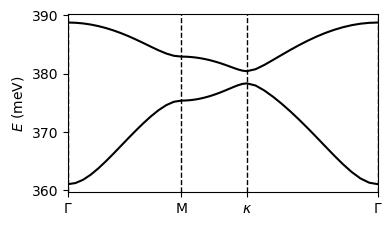

In [34]:
params.plot_dispersion(k=2)

In [12]:
val,vec,_=params.energy_single(0,0)

In [13]:
vec[:,0]

array([-0.11712239-1.04247298e-02j, -0.11712239+1.04247298e-02j,
       -0.11712239+1.04247298e-02j,  0.65691434+0.00000000e+00j,
       -0.11712239-1.04247298e-02j, -0.11712239-1.04247298e-02j,
       -0.11712239+1.04247298e-02j, -0.1140981 +1.41294117e-03j,
       -0.1140981 -1.41294117e-03j, -0.1140981 -1.41294117e-03j,
        0.63826588+4.16333634e-17j, -0.1140981 +1.41294117e-03j,
       -0.1140981 +1.41294117e-03j, -0.1140981 -1.41294117e-03j])

In [14]:
vec[:,1]

array([-0.00247781-2.92316941e-01j, -0.00247781+2.92316941e-01j,
       -0.00247781+2.92316941e-01j,  0.00184735-4.74338450e-20j,
       -0.00247781-2.92316941e-01j, -0.00247781-2.92316941e-01j,
       -0.00247781+2.92316941e-01j,  0.00561901-2.84758513e-01j,
        0.00561901+2.84758513e-01j,  0.00561901+2.84758513e-01j,
       -0.02346664-8.88110657e-15j,  0.00561901-2.84758513e-01j,
        0.00561901-2.84758513e-01j,  0.00561901+2.84758513e-01j])

## Wavefunction

In [46]:
params=Params(Nmax=1)

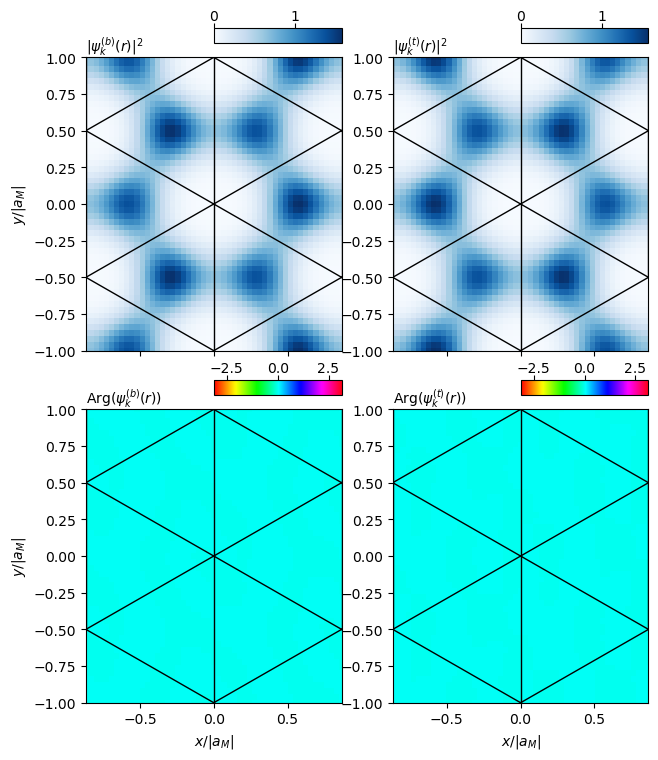

In [43]:
ub2,ut2,ub_arg,ut_arg,_,_=params.plot_psi(0,0,state=0)

In [44]:
ub2[3,5]-ut2[3,5]

-0.0753592020398226

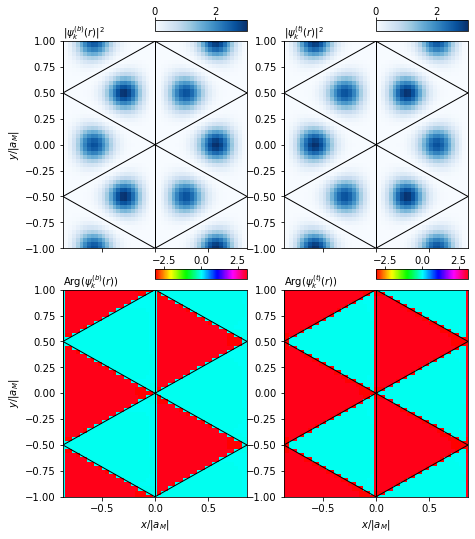

In [1490]:
ub2,ut2,ub_arg,ut_arg,_,_=params.plot_psi(0.00,0,state=1)

In [1608]:
params=Params(Nmax=4,Ez=1,)

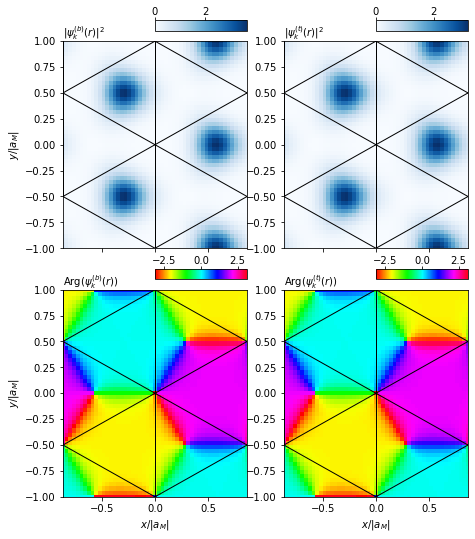

In [1601]:
ub2,ut2,ub_arg,ut_arg,rx_mat,ry_mat=params.plot_psi(*(params.high_symm['kappa']),state=0)

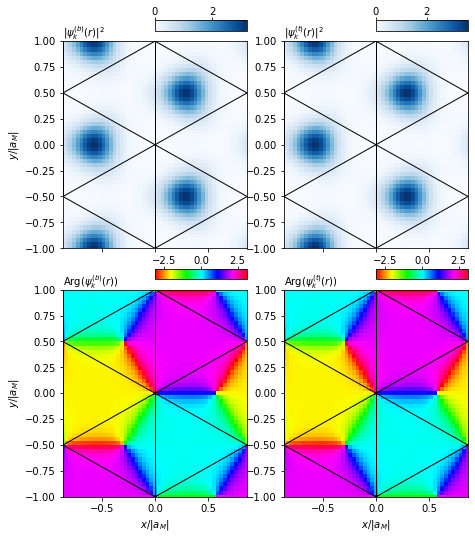

In [1598]:
ub2,ut2,ub_arg,ut_arg,rx_mat,ry_mat=params.plot_psi(*(params.high_symm['kappa']),state=1)

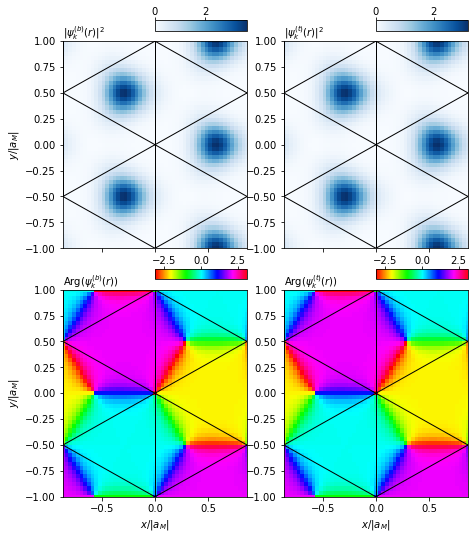

In [1609]:
ub2,ut2,ub_arg,ut_arg,rx_mat,ry_mat=params.plot_psi(*(params.high_symm['kappa']@_rotate(deg2rad(-120))),state=0)

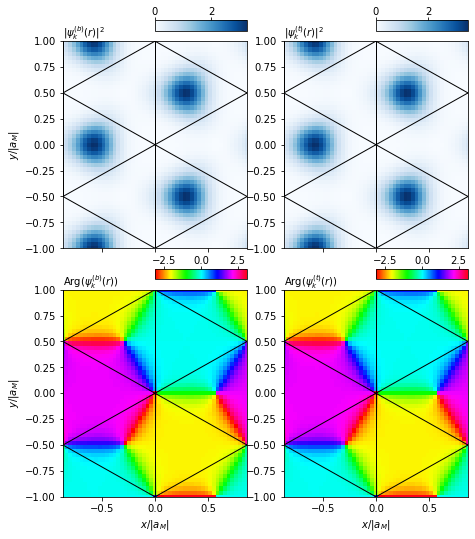

In [1564]:
ub2,ut2,ub_arg,ut_arg,rx_mat,ry_mat=params.plot_psi(*(params.high_symm['kappa']@_rotate(deg2rad(-120))),state=1)

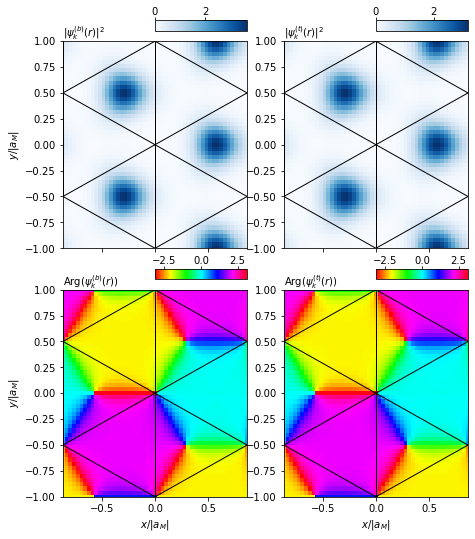

In [1610]:
ub2,ut2,ub_arg,ut_arg,rx_mat,ry_mat=params.plot_psi(*(params.high_symm['kappa']@_rotate(deg2rad(120))),state=0)

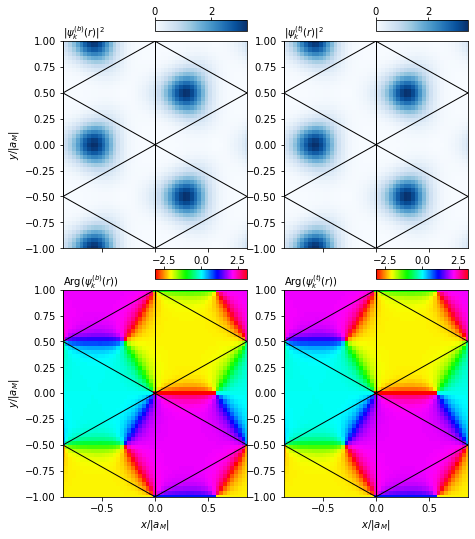

In [1566]:
ub2,ut2,ub_arg,ut_arg,rx_mat,ry_mat=params.plot_psi(*(params.high_symm['kappa']@_rotate(deg2rad(120))),state=1)

## test

In [1638]:
params=Params(Nmax=10,Ez=100,)

In [1617]:
params_1=Params(Nmax=1,Ez=100,)

In [1639]:
val,vec,_=params.energy_single(*(params.high_symm['kappa']))
pt0=(params.aM1+params.aM2)/3
pt1=pt0@_rotate(deg2rad(120))
pt2=pt0@_rotate(deg2rad(240))

In [1518]:
ub0,ut0=params.psi(vec[:,0],*pt0,*(params.high_symm['kappa']))
ub1,ut1=params.psi(vec[:,0],*pt1,*(params.high_symm['kappa']))
ub2,ut2=params.psi(vec[:,0],*pt2,*(params.high_symm['kappa']))

In [1640]:
val0,vec0,_=params.energy_single(*(params.high_symm['kappa']@_rotate(deg2rad(0))))
val1,vec1,_=params.energy_single(*(params.high_symm['kappa']@_rotate(deg2rad(120))))
val2,vec2,_=params.energy_single(*(params.high_symm['kappa']@_rotate(deg2rad(240))))
pt0=(params.aM1+params.aM2)/3
# pt1=pt0@_rotate(deg2rad(120))
# pt2=pt0@_rotate(deg2rad(240))

In [1592]:
ub0,ut0=params.psi(vec0[:,0],*(pt0+np.array([0,10])),*(params.high_symm['kappa']))
ub1,ut1=params.psi(vec1[:,0],*(pt0+np.array([0,10])),*(params.high_symm['kappa']@_rotate(deg2rad(120))))
ub2,ut2=params.psi(vec2[:,0],*(pt0+np.array([0,10])),*(params.high_symm['kappa']@_rotate(deg2rad(240))))


In [1641]:
vec_dict0={(h1,h2):vec for h1,h2,vec in zip(params.h1index,params.h2index,vec0[:,0])}
vec_dict1={(h1,h2):vec for h1,h2,vec in zip(params.h1index,params.h2index,vec1[:,0])}
vec_dict2={(h1,h2):vec for h1,h2,vec in zip(params.h1index,params.h2index,vec2[:,0])}

In [1637]:
pd.DataFrame({'vec0':[vec_dict0[(h1,h2)] for h1,h2 in zip(params_1.h1index,params_1.h2index)],'vec2':[vec_dict2[(h1,h2)] for h1,h2 in zip(params_1.h1index,params_1.h2index)]},index=h_str)

,vec0,vec2
"(-1,-1)",-0.218666-0.378741j,-0.049359-0.036137j
"(0,-1)",-0.218666+0.378741j,-0.065464+0.113387j
"(-1,0)",-0.065464+0.113387j,-0.049359+0.036137j
"(0,0)",0.437332-0.000000j,0.437332-0.000000j
"(1,0)",-0.065464-0.113387j,-0.218666-0.378741j
"(0,1)",-0.049359-0.036137j,-0.065464-0.113387j
"(1,1)",-0.049359+0.036137j,-0.218666+0.378741j


In [1645]:
r=[0,1]

In [1649]:
np.sum([vec_dict0[(h1,h2)]*np.exp(1j*(h1*params.bM1+h2*params.bM2)@np.array(r)) for h1,h2 in zip(params_1.h1index,params_1.h2index)])

(-0.20911260940202966+0.015049550004638396j)

In [ ]:
np.sum([vec_dict2[(h1,h2)]*np.exp(1j*(h1*params.bM1+h2*params.bM2+ )@np.array(r)) for h1,h2 in zip(params_1.h1index,params_1.h2index)])

(-0.20911260940202966+0.015049550004638396j)

In [1642]:
pd.DataFrame({'vec0':[vec_dict0[(h1,h2)] for h1,h2 in zip(params_1.h1index,params_1.h2index)],'vec2':[vec_dict2[(h1,h2)] for h1,h2 in zip(params_1.h1index,params_1.h2index)]},index=h_str)

,vec0,vec2
"(-1,-1)",-0.218666-0.378741j,-0.049359-0.036137j
"(0,-1)",-0.218666+0.378741j,-0.065464+0.113387j
"(-1,0)",-0.065464+0.113387j,-0.049359+0.036137j
"(0,0)",0.437332-0.000000j,0.437332+0.000000j
"(1,0)",-0.065464-0.113387j,-0.218666-0.378741j
"(0,1)",-0.049359-0.036137j,-0.065464-0.113387j
"(1,1)",-0.049359+0.036137j,-0.218666+0.378741j


In [1593]:
(np.angle(ub0)-np.angle(ub1))/np.pi

array([0.66666667])

In [1584]:
ub0,ut0

(array([-0.95836587+1.65993838j]), array([-0.89557578+1.55118275j]))

In [1585]:
ub1,ut1

(array([1.91673174-1.9519129e-11j]), array([1.79115156-1.82411377e-11j]))

In [1586]:
ub2,ut2

(array([-0.95836587-1.65993838j]), array([-0.89557578-1.55118275j]))

In [1426]:
params.high_symm['kappa']@

array([0.05712799, 0.03298286])

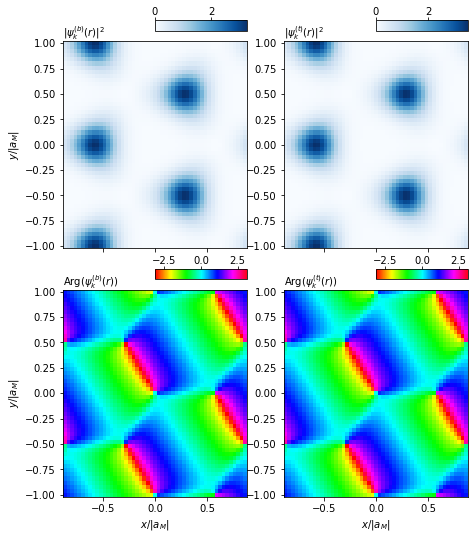

In [991]:
ub2,ut2,ub_arg,ut_arg=params.plot_psi(*(params.high_symm['kappa']),state=1)

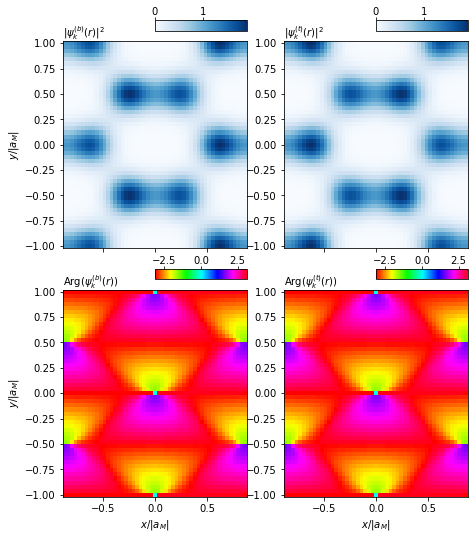

In [ ]:
ub2,ut2,ub_arg,ut_arg=params.plot_psi(*params.high_symm['kappa_p'],state=0)

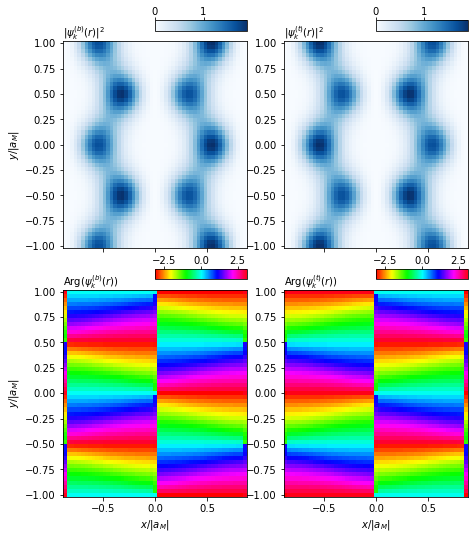

In [ ]:
ub2,ut2,ub_arg,ut_arg=params.plot_psi(*params.high_symm['kappa_p'],state=1)

In [1285]:
params_1=Params(Nmax=1)

In [1271]:
params=Params(Nmax=10)

In [1284]:
params=Params(Nmax=10, Ez=100)

In [1273]:
val,vec,H=params.energy_single(*(params.high_symm['Gamma']))
val_1,vec_1,H_1=params.energy_single(*(params.high_symm['kappa']))

In [1249]:
val_1[:2]

array([364.0417596 , 357.56886425])

In [1622]:
h_str=['({},{})'.format(h1,h2) for h1,h2, in np.array([params.h1index,params.h2index]).T]

In [1290]:
h_dict={tuple(h):idx for idx,h in enumerate(np.array([params.h1index,params.h2index]).T)}

In [1286]:
h_1_tuple=[(h1,h2) for h1,h2 in np.array([params_1.h1index,params_1.h2index]).T]

In [1292]:
h1_slice_idx=[h_dict[h1] for h1 in h_1_tuple]

In [1295]:
pd.DataFrame(H_1[np.ix_(h1_slice_idx,h1_slice_idx)])

,0,1,2,3,4,5,6
0,84.487877+0.000000j,-3.090228+5.143004j,-3.090228+5.143004j,-3.090228-5.143004j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
1,-3.090228-5.143004j,84.487877+0.000000j,0.000000+0.000000j,-3.090228+5.143004j,-3.090228-5.143004j,0.000000+0.000000j,0.000000+0.000000j
2,-3.090228-5.143004j,0.000000+0.000000j,37.95151+0.00000j,-3.090228+5.143004j,0.000000+0.000000j,-3.090228-5.143004j,0.000000+0.000000j
3,-3.090228+5.143004j,-3.090228-5.143004j,-3.090228-5.143004j,84.487877+0.000000j,-3.090228+5.143004j,-3.090228+5.143004j,-3.090228-5.143004j
4,0.000000+0.000000j,-3.090228+5.143004j,0.000000+0.000000j,-3.090228-5.143004j,37.95151+0.00000j,0.000000+0.000000j,-3.090228+5.143004j
5,0.000000+0.000000j,0.000000+0.000000j,-3.090228+5.143004j,-3.090228-5.143004j,0.000000+0.000000j,-8.584858+0.000000j,-3.090228+5.143004j
6,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,-3.090228+5.143004j,-3.090228-5.143004j,-3.090228-5.143004j,-8.584858+0.000000j


In [1277]:
pd.DataFrame(np.round(H_1[:params.h1index.shape[0],:params.h1index.shape[0]],3),columns=h_str,index=h_str)

,"(-10,-10)","(-9,-10)","(-8,-10)","(-7,-10)","(-6,-10)","(-5,-10)","(-4,-10)","(-3,-10)","(-2,-10)","(-1,-10)",...,"(1,10)","(2,10)","(3,10)","(4,10)","(5,10)","(6,10)","(7,10)","(8,10)","(9,10)","(10,10)"
"(-10,-10)",-4103.785+0.000j,-3.0900+5.1430j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.000+0.000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000+0.000j,0.000+0.000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j
"(-9,-10)",-3.0900-5.1430j,-3684.958+0.000j,-3.0900+5.1430j,0.0000+0.0000j,0.0000+0.0000j,0.000+0.000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000+0.000j,0.000+0.000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j
"(-8,-10)",0.0000+0.0000j,-3.0900-5.1430j,-3359.203+0.000j,-3.0900+5.1430j,0.0000+0.0000j,0.000+0.000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000+0.000j,0.000+0.000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j
"(-7,-10)",0.0000+0.0000j,0.0000+0.0000j,-3.0900-5.1430j,-3126.521+0.000j,-3.0900+5.1430j,0.000+0.000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000+0.000j,0.000+0.000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j
"(-6,-10)",0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,-3.0900-5.1430j,-2986.912+0.000j,-3.090+5.143j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000+0.000j,0.000+0.000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(6,10)",0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.000+0.000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,-3.090-5.143j,-3917.64+0.00j,-3.0900+5.1430j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j
"(7,10)",0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.000+0.000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000+0.000j,-3.090-5.143j,-4057.249+0.000j,-3.0900+5.1430j,0.0000+0.0000j,0.0000+0.0000j
"(8,10)",0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.000+0.000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000+0.000j,0.000+0.000j,-3.0900-5.1430j,-4289.931+0.000j,-3.0900+5.1430j,0.0000+0.0000j
"(9,10)",0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.000+0.000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000+0.000j,0.000+0.000j,0.0000+0.0000j,-3.0900-5.1430j,-4615.685+0.000j,-3.0900+5.1430j


In [1270]:
pd.DataFrame(np.round(perm@H_1[:7,:7]@perm.T,3),columns=h_str,index=h_str)

,"(-1,-1)","(0,-1)","(-1,0)","(0,0)","(1,0)","(0,1)","(1,1)"
"(-1,-1)",-8.585+0.000j,-3.090+5.143j,-3.090+5.143j,-3.090-5.143j,0.000+0.000j,0.000+0.000j,0.000+0.000j
"(0,-1)",-3.090-5.143j,37.952+0.000j,0.000+0.000j,-3.090+5.143j,-3.090-5.143j,0.000+0.000j,0.000+0.000j
"(-1,0)",-3.090-5.143j,0.000+0.000j,-8.585+0.000j,-3.090+5.143j,0.000+0.000j,-3.090-5.143j,0.000+0.000j
"(0,0)",-3.090+5.143j,-3.090-5.143j,-3.090-5.143j,84.488+0.000j,-3.090+5.143j,-3.090+5.143j,-3.090-5.143j
"(1,0)",0.000+0.000j,-3.090+5.143j,0.000+0.000j,-3.090-5.143j,84.488+0.000j,0.000+0.000j,-3.090+5.143j
"(0,1)",0.000+0.000j,0.000+0.000j,-3.090+5.143j,-3.090-5.143j,0.000+0.000j,37.952+0.000j,-3.090+5.143j
"(1,1)",0.000+0.000j,0.000+0.000j,0.000+0.000j,-3.090+5.143j,-3.090-5.143j,-3.090-5.143j,84.488+0.000j


In [1262]:
perm=params._generate_permutation()

In [1265]:
perm@H[:7,:7]@perm.T

array([[ 2.13162821e-14+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j, -2.13162821e-14+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j, -2.13162821e-14+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j

In [1182]:
h0=np.array([params.h1index,params.h2index]).T

In [1209]:
h1=np.rint(np.array([params.h1index,params.h2index]).T@np.array([params.bM1,params.bM2])@_rotate(deg2rad(120))@np.linalg.inv(np.array([params.bM1,params.bM2]))).astype('int')

In [1188]:
h0_dict

{(-1, -1): 0,
 (0, -1): 1,
 (-1, 0): 2,
 (0, 0): 3,
 (1, 0): 4,
 (0, 1): 5,
 (1, 1): 6}

In [1236]:
h0.shape

(7, 2)

In [1234]:
np.unique(h1_idx).shape[0]

7

In [1224]:
h2_idx=[h0_dict[tuple(h)] for h in h1]

In [1213]:
h1_idx=np.arange(7)

In [1214]:
from scipy.sparse import csc_matrix

In [1227]:
perm=csc_matrix(([1]*7,(h1_idx,h2_idx)))

In [1232]:
np.round(perm@H[:7,:7]@perm.T-H[:7,:7],3)

array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]])

In [1168]:
pt0

array([[-0.11425597,  0.        ],
       [-0.05712799, -0.09894858],
       [-0.05712799,  0.09894858],
       [ 0.        ,  0.        ],
       [ 0.05712799, -0.09894858],
       [ 0.05712799,  0.09894858],
       [ 0.11425597,  0.        ]])

In [1143]:
pd.DataFrame({'u_b':np.round(vec[:,0],4)[:params.h1index.shape[0]],'u_t':np.round(vec[:,0],4)[params.h1index.shape[0]:],'h1':params.h1index,'h2':params.h2index})

,u_b,u_t,h1,h2
0,-0.1269-0.0520j,-0.0981-0.0302j,-1,-1
1,-0.1269+0.0520j,-0.0981+0.0302j,0,-1
2,-0.1269+0.0520j,-0.0981+0.0302j,-1,0
3,0.7251+0.0000j,0.5459+0.0000j,0,0
4,-0.1269-0.0520j,-0.0981-0.0302j,1,0
5,-0.1269-0.0520j,-0.0981-0.0302j,0,1
6,-0.1269+0.0520j,-0.0981+0.0302j,1,1


In [1144]:
pd.DataFrame({'u_b':np.round(vec_1[:,0],4)[:params.h1index.shape[0]],'u_t':np.round(vec_1[:,0],4)[params.h1index.shape[0]:],'h1':params.h1index,'h2':params.h2index})

,u_b,u_t,h1,h2
0,-0.1762-0.4014j,-0.1282-0.2978j,-1,-1
1,-0.1762+0.4014j,-0.1282+0.2978j,0,-1
2,-0.0665+0.1282j,-0.0475+0.0933j,-1,0
3,0.4622+0.0000j,0.3392+0.0000j,0,0
4,-0.0665-0.1282j,-0.0475-0.0933j,1,0
5,-0.0511-0.0405j,-0.0395-0.0269j,0,1
6,-0.0511+0.0405j,-0.0395+0.0269j,1,1


In [310]:
pd.DataFrame({'u_b':np.round(vec[:,1],4)[:params.h1index.shape[0]],'u_t':np.round(vec[:,0],4)[params.h1index.shape[0]:],'h1':params.h1index,'h2':params.h2index})

,u_b,u_t,h1,h2
0,-0.0032+0.0703j,0.0016-0.0029j,-2,-2
1,0.0072+0.0000j,0.1423+0.0000j,-1,-2
2,-0.0032-0.0703j,0.0016+0.0029j,0,-2
3,0.0042+0.0385j,0.0612+0.0013j,-2,-1
4,-0.0045-0.4748j,-0.2726+0.0077j,-1,-1
5,-0.0045+0.4748j,-0.2726-0.0077j,0,-1
6,0.0042-0.0385j,0.0612-0.0013j,1,-1
7,-0.0005-0.0154j,-0.0056+0.0008j,-2,0
8,-0.0037+0.1285j,-0.0747-0.0064j,-1,0
9,0.0090+0.0000j,0.5504+0.0000j,0,0


In [ ]:
np.c_[np.round(vec[:,0],4)[params.h1index.shape[0]:],params.h1index,params.h2index]

In [ ]:
np.c_[np.round(vec[:,1],4)[:7],params.h1index,params.h2index]

In [ ]:
np.c_[np.round(vec[:,1],4)[7:],params.h1index,params.h2index]

In [190]:
np.abs(np.array(params.u(vec[:,0],0.5*params.aM,0)))**2

array([[1.41946546],
       [1.25470514]])

In [191]:
np.abs(np.array(params.u(vec[:,0],0.5*params.aM*np.cos(deg2rad(120)),0.5*params.aM*np.sin(deg2rad(120)))))**2

array([[1.79108402],
       [1.58424825]])

In [192]:
np.abs(np.array(params.u(vec[:,0],0.5*params.aM*np.cos(deg2rad(240)),0.5*params.aM*np.sin(deg2rad(240)))))**2

array([[1.41946546],
       [1.25470514]])

In [156]:
params.u(vec[:,0],1,0)

(array([-0.01469381+0.01790161j]), array([-0.01469969+0.01785895j]))

In [157]:
params.u(vec[:,0],np.cos(deg2rad(120)),np.sin(deg2rad(120)))

(array([-0.01095476+0.0203182j]), array([-0.01099287+0.02038888j]))

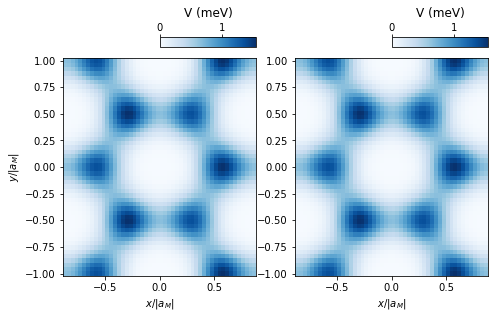

In [ ]:
params.plot_psi(0,0)

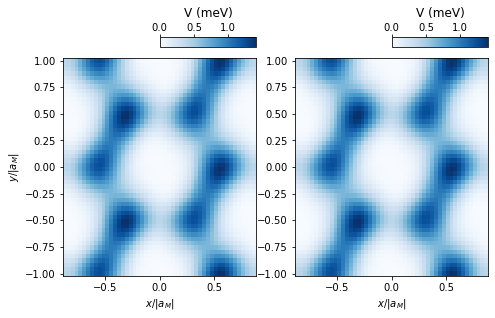

In [69]:
params.plot_psi(.1,.1)

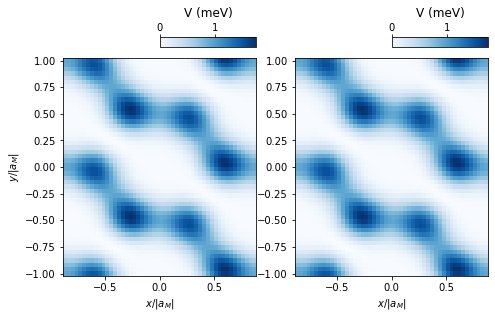

In [67]:
params.plot_psi(*params.high_symm['M'])

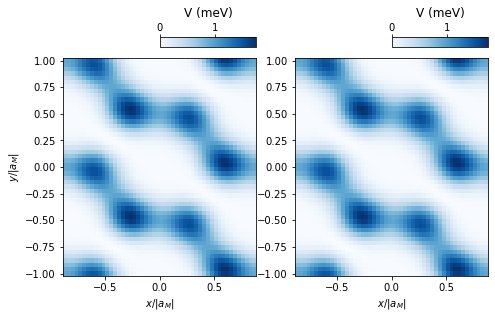

In [68]:
params.plot_psi(*(-params.high_symm['M']))

In [44]:
val,vec,H=params.energy_single(0,0)

In [25]:
params.u(vec[:,0],np.array([1]),np.array([0]))

1


(array([0.05570725+0.0622384j]), array([0.05570811+0.06223936j]))

In [27]:
a=np.linspace(0,1,5)
b=np.linspace(0,1,10)

In [30]:
aa,bb=np.meshgrid(a,b,indexing='ij')

In [31]:
aa.shape

(5, 10)

## Band structure

In [ ]:
Params(Nmax=2)

In [1551]:
# params=Params(Nmax=4,theta=1.1)
params=Params(Nmax=4,Ez=100,phi=120)
params_2=Params(Nmax=4,Ez=100,phi=90)

(250.0, 390.0)

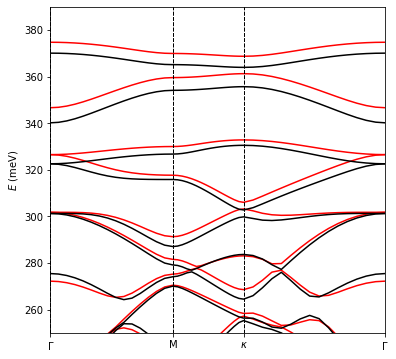

In [1553]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=params.plot_dispersion(k=10,ax=ax,color='r')
energy_list=params_2.plot_dispersion(k=10,ax=ax,color='k')
# energy_list_4=params_4.plot_dispersion(k=6,ax=ax,color='b')
# ax.set_ylim(-400,-300)
# ax.set_ylim(330,385)
ax.set_ylim(250,390)



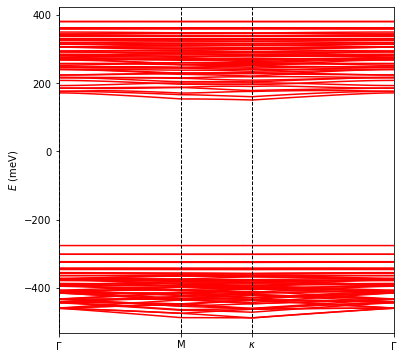

In [1136]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=params.plot_dispersion(k=1000,ax=ax,color='r')
# energy_list_4=params_4.plot_dispersion(k=6,ax=ax,color='b')
# ax.set_ylim(-400,-300)
# ax.set_ylim(330,385)


In [895]:
energy_list[:,0].max()-energy_list[:,1].min()

0.45031032450623343

In [896]:
energy_list[:,2].max()-energy_list[:,5].min()

3.5511050099703425

In [897]:
energy_list[:,6].max()-energy_list[:,8].min()

5.745244854605403

In [ ]:
phi_list=np.linspace(0,360,37)
for phi in phi_list:
    params=Params(Ez=0,phi=phi)
    fig,ax=plt.subplots(figsize=(4,8/params.aM1[0]*params.aM2[1]))
    params.plot_dispersion(k=10,ax=ax,color='k')

    ax.set_ylim(250,365)
    fig.savefig('E_{:.0f}.png'.format(params.phi/np.pi*180),dpi=1000)

## Bandstructure in 1BZ

In [484]:
params=Params()

(-0.12568157161923943,
 0.12568157161923943,
 -0.10884343380981466,
 0.1425197094286642)

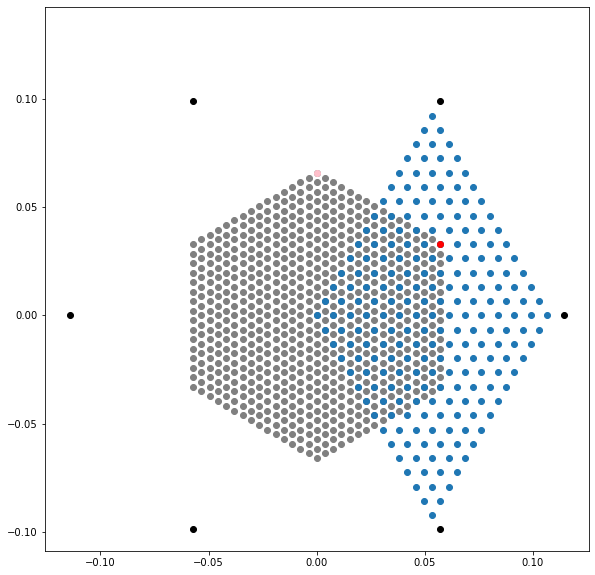

In [488]:
plt.figure(figsize=(10,10))
plt.scatter(*params.high_symm['hex'].T,color='gray')
plt.scatter(*params.high_symm['diamond'].T)
plt.scatter(*np.array(params.g).T,color='k')
plt.scatter(*(params.high_symm['kappa']),color='r')
plt.scatter(*(params.high_symm['kappa_p']),color='pink')
plt.axis('square')

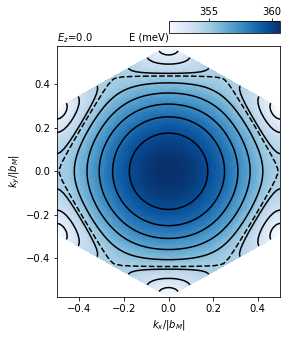

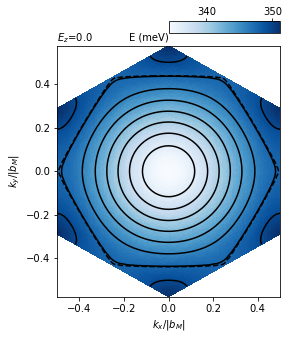

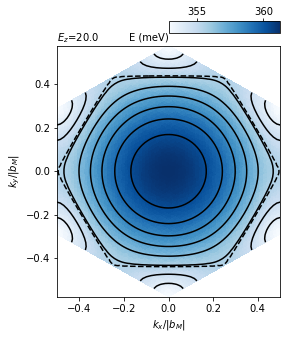

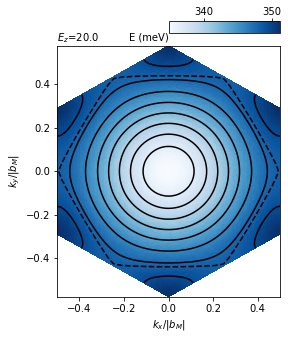

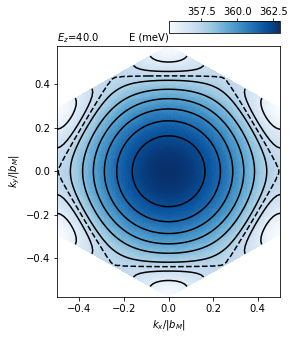

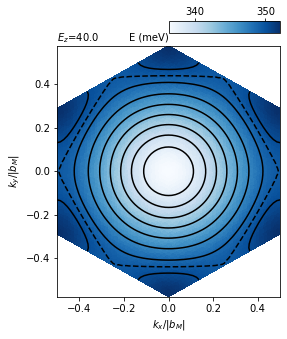

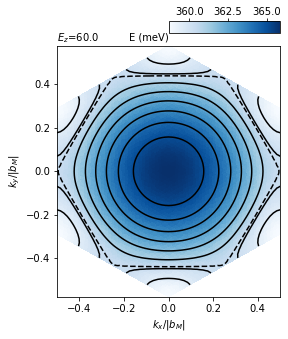

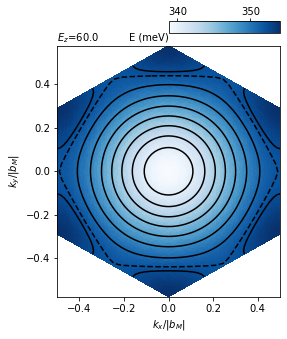

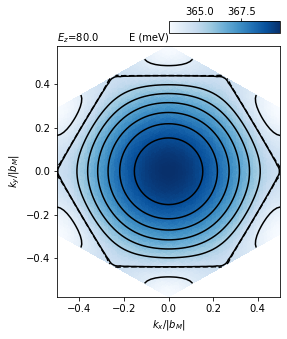

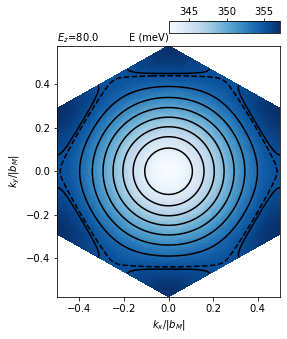

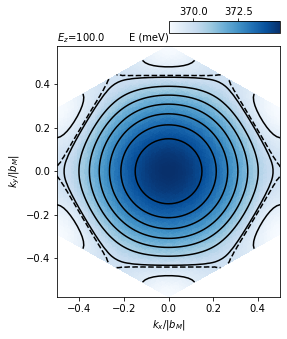

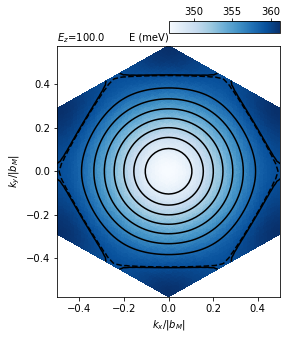

In [977]:
for Ez,vh in zip(Ez_list,vH):
    params=Params(n=33,Ez=Ez)
    energy_list=params.plot_bandstructure(state=0,vH=vh[0])
    energy_list=params.plot_bandstructure(state=1,vH=vh[1])

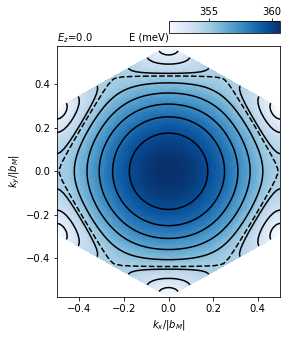

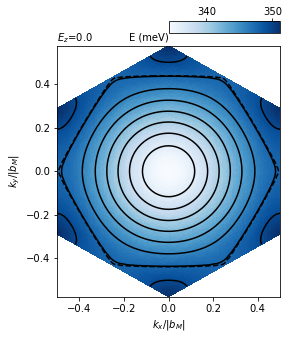

In [ ]:
for Ez,vh in zip(Ez_list,vH):
    params=Params(n=33,Ez=Ez)
    energy_list=params.plot_bandstructure(state=0,vH=vh[0])
    energy_list=params.plot_bandstructure(state=1,vH=vh[1])

## LDOS and van Hove singluarity

In [878]:
params=Params(n=105,)

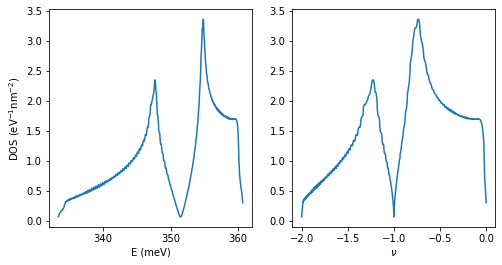

In [880]:
energy_range,filling_range,dos,energy_map=params.plot_LDOS()

In [876]:
Ez_list=np.linspace(0,100,6)
energy_range_list=[]
filling_range_list=[]
dos_list=[]
for Ez in Ez_list:
    print(Ez)
    params=Params(n=105,Ez=Ez)
    energy_range,filling_range,dos,_=params.plot_LDOS(ax=False)
    energy_range_list.append(energy_range)
    filling_range_list.append(filling_range)
    dos_list.append(dos)

0.0
20.0
40.0
60.0
80.0
100.0


Text(0, 0.5, 'DOS (eV$^{-1}$nm$^{-2}$)')

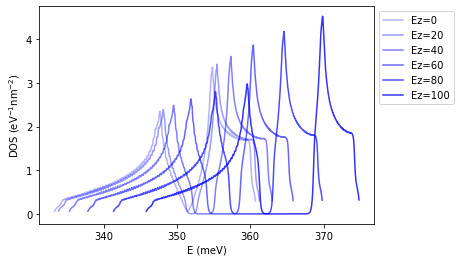

In [942]:
fig,ax=plt.subplots()
alpha_list=np.linspace(.3,.8,Ez_list.shape[0])
for energy_range,dos,Ez,alpha in zip(energy_range_list,dos_list,Ez_list,alpha_list):
    ax.plot(energy_range,dos,label='Ez={:.0f}'.format(Ez),alpha=alpha,color='blue')
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
ax.set_xlabel('E (meV)')
ax.set_ylabel('DOS (eV$^{-1}$nm$^{-2}$)')


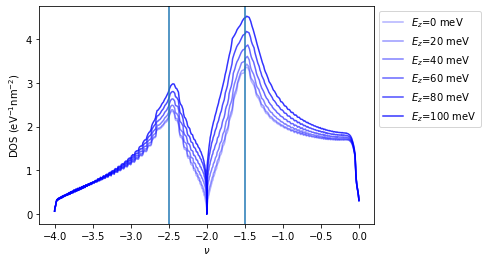

In [976]:
fig,ax=plt.subplots()
alpha_list=np.linspace(.3,.8,Ez_list.shape[0])
for filling_range,dos,Ez,alpha in zip(filling_range_list,dos_list,Ez_list,alpha_list):
    ax.plot(2*filling_range,dos,label='$E_z$={:.0f} meV'.format(Ez),alpha=alpha,color='blue')
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
ax.set_xlabel(r'$\nu$')
ax.set_ylabel('DOS (eV$^{-1}$nm$^{-2}$)')
ax.axvline(x=-2.5)
ax.axvline(x=-1.5)

In [938]:
vH=[(energy_range[filling_range>-1][dos[filling_range>-1].argmax()],energy_range[filling_range<-1][dos[filling_range<-1].argmax()]) for energy_range,filling_range,dos in zip(energy_range_list,filling_range_list,dos_list)]

## symmetry check

In [1017]:
def check_TRS(kx,ky):
    params_t1=Params(Nmax=2,)
    params_tm1=Params(Nmax=2,t=-1)
    val_t1,vec_t1,H_t1=params_t1.energy_single(kx,ky)
    val_tm1,vec_tm1,H_tm1=params_tm1.energy_single(kx,ky)
    return H_t1,H_tm1,np.abs(H_t1-H_tm1).max()

In [1018]:
H_t1,H_tm1,diff=check_TRS(0,0.1)
diff

0.0

In [1051]:
def check_C2y(kx,ky,Ez=0):
    # Note: kx->-kx, ky->-ky
    params_=Params(Nmax=2,Ez=Ez)
    params_1=Params(Nmax=2,C2y=-1,Ez=Ez)
    val_,vec_,H_=params_.energy_single(kx,ky)
    val_1,vec_1,H_1=params_1.energy_single(kx,ky)
    return H_,H_1,np.abs(H_-H_1).max()


In [1055]:
H_,H_1,diff=check_C2y(0,1)
diff

0.0

## Test C2y relate two valence bands

In [93]:
params_1=Params(Nmax=1)
# params_m1=Params(Nmax=2,C2y=-1)
val_1,vec_1,H_1=params_1.energy_single(0.05,0)
val_m1,vec_m1,H_m1=params_1.energy_single(-0.05,0)
# val_m1,vec_m1,H_m1=params_m1.energy_single(*params_m1.high_symm['Gamma'])

In [91]:
np.c_[params_1.h1index,params_1.h2index]

array([[-1, -1],
       [ 0, -1],
       [-1,  0],
       [ 0,  0],
       [ 1,  0],
       [ 0,  1],
       [ 1,  1]])

In [109]:
np.c_[params_1.h1index,params_1.h2index]@np.array([params_1.bM1,params_1.bM2])

array([[-0.11425597,  0.        ],
       [-0.05712799, -0.09894858],
       [-0.05712799,  0.09894858],
       [ 0.        ,  0.        ],
       [ 0.05712799, -0.09894858],
       [ 0.05712799,  0.09894858],
       [ 0.11425597,  0.        ]])

In [79]:
vec_1[0,0]

(-0.0013478367796867811+0j)

In [ ]:
vec_1[9,0]

(-0.0013478367796867811+0j)

In [97]:
np.exp(-np.angle(vec_1[3,0]))

3.1203266861585397

In [106]:
np.round(vec_1[:,0]*np.exp(-1j*np.angle(vec_1[3,0])),4).reshape((2,-1))

array([[-0.2975-0.0063j, -0.0814+0.0067j, -0.0814+0.0067j,
         0.6119+0.j    , -0.0975-0.0052j, -0.0975-0.0052j,
        -0.0673+0.0049j],
       [-0.2975+0.0045j, -0.0814-0.0072j, -0.0814-0.0072j,
         0.6119+0.0037j, -0.0976+0.0046j, -0.0976+0.0046j,
        -0.0672-0.0053j]])

In [108]:
np.round(vec_m1[:,0]*np.exp(-1j*np.angle(vec_m1[10,0])),4).reshape((2,-1))

array([[-0.0672-0.0053j, -0.0976+0.0046j, -0.0976+0.0046j,
         0.6119+0.0037j, -0.0814-0.0072j, -0.0814-0.0072j,
        -0.2975+0.0045j],
       [-0.0673+0.0049j, -0.0975-0.0052j, -0.0975-0.0052j,
         0.6119+0.j    , -0.0814+0.0067j, -0.0814+0.0067j,
        -0.2975-0.0063j]])

In [88]:
np.round(vec_1[:,1],4)

array([-2.886e-01+0.j    ,  2.885e-01+0.0081j,  2.885e-01+0.0081j,
        2.000e-04-0.0128j, -2.886e-01-0.j    , -2.886e-01-0.j    ,
        2.885e-01+0.0081j, -2.885e-01-0.0081j,  2.886e-01-0.j    ,
        2.886e-01+0.j    , -2.000e-04+0.0128j, -2.885e-01-0.0081j,
       -2.885e-01-0.0081j,  2.886e-01-0.j    ])

In [1048]:
vec_m1[:,0]

array([-1.34783678e-03+0.00000000e+00j,  2.18911306e-02+2.44576597e-02j,
        1.48814570e-04-1.33959629e-03j,  2.18911306e-02+2.44576597e-02j,
       -7.78152560e-02-9.63656928e-02j, -8.71849485e-02-8.79792337e-02j,
        2.18911306e-02+2.44576597e-02j,  1.48814570e-04-1.33959629e-03j,
       -8.71849485e-02-8.79792337e-02j,  4.22580452e-01+4.72124035e-01j,
       -7.78152560e-02-9.63656928e-02j, -1.34783678e-03+2.21023495e-17j,
        2.18911306e-02+2.44576597e-02j, -7.78152560e-02-9.63656928e-02j,
       -8.71849485e-02-8.79792337e-02j,  2.18911306e-02+2.44576597e-02j,
       -1.34783678e-03+4.87330654e-17j,  2.18911306e-02+2.44576597e-02j,
        1.48814570e-04-1.33959629e-03j,  1.48814570e-04-1.33959629e-03j,
        2.18911306e-02+2.44576597e-02j, -1.34783678e-03-5.68540093e-17j,
        2.18911306e-02+2.44576597e-02j, -8.71849485e-02-8.79792337e-02j,
       -7.78152560e-02-9.63656928e-02j,  2.18911306e-02+2.44576597e-02j,
       -1.34783678e-03-2.69029243e-17j, -7.78152560

## Bonding vs Antibonding

In [1038]:
params_3=Params(Nmax=3)
val,vec,H_=params_3.energy_single(0,0)
# val,vec,H_=params_3.energy_single(*params_3.high_symm['kappa'])

In [1039]:
bonding_proj=np.kron(np.outer([1,1],[1,1])/2,np.eye(vec.shape[0]//2))
antibonding_proj=np.kron(np.outer([1,-1],[1,-1])/2,np.eye(vec.shape[0]//2))

In [1040]:
bonding_component=np.array([vec[:,idx].conj()@bonding_proj@vec[:,idx] for idx in range(vec.shape[0])])
antibonding_component=np.array([vec[:,idx].conj()@antibonding_proj@vec[:,idx] for idx in range(vec.shape[0])])

Text(0, 0.5, 'projecting to bonding state')

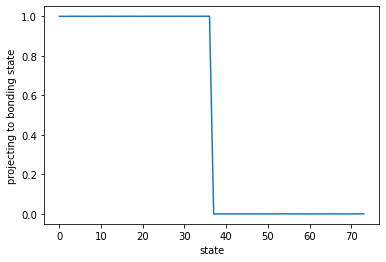

In [1041]:
fig,ax=plt.subplots()
ax.plot(bonding_component.real)
ax.set_xlabel('state')
ax.set_ylabel('projecting to bonding state')

## Gap vs Field

In [25]:
Ez_list=np.linspace(0,600)
gap12_list=[]
gap23_list=[]
for Ez in Ez_list:
    params=Params(Nmax=4,Ez=Ez,V0=-8.5,phi=-0.176364/(2*np.pi)*360,w0=356,w1=-9)
    # params=Params(Nmax=4,Ez=Ez)
    en_list=params.plot_dispersion(k=6,ax=False)
    gap12_list.append(en_list[:,0].min()-en_list[:,1].max())
    gap23_list.append(en_list[:,1].min()-en_list[:,2].max())
gap12_list=np.array(gap12_list)
gap23_list=np.array(gap23_list)
    

    

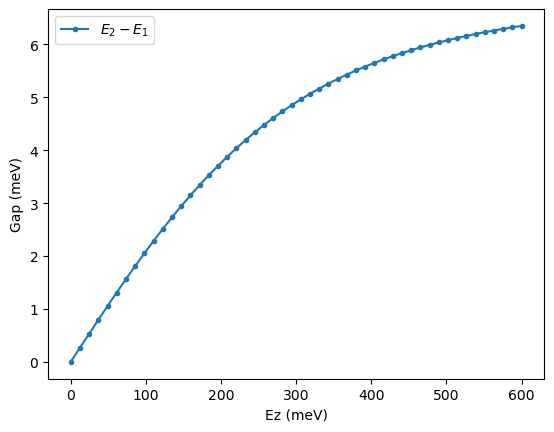

In [26]:
fig,ax=plt.subplots()
ax.plot(Ez_list,gap12_list,'.-',label='$E_2-E_1$')
# ax.plot(Ez_list,gap23_list,'.-',label='$E_3-E_2$')
ax.set_xlabel('Ez (meV)')
ax.set_ylabel('Gap (meV)')
ax.legend()

In [716]:
phi_list=np.linspace(0,180,20)
bandwidth_list=[]
bandgap_list=[]
for phi in phi_list:
    params=Params(Nmax=4,phi=phi,m=0.)
    en_list=params.plot_dispersion(k=6,ax=False)
    bandwidth_list.append(en_list[0,0]-en_list[0,1])
    bandgap_list.append(en_list[0,1]-en_list[0,2])
bandwidth_list=np.array(bandwidth_list)
bandgap_list=np.array(bandgap_list)  

    

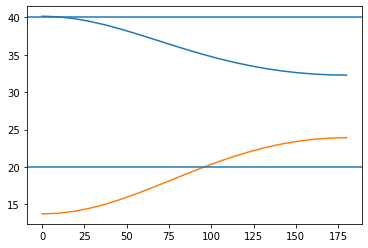

In [717]:
fig,ax=plt.subplots()
ax.plot(phi_list,bandwidth_list)
ax.plot(phi_list,bandgap_list)
ax.axhline(y=40)
ax.axhline(y=20)


## Real space potential

In [6]:
params=Params(Ez=0)

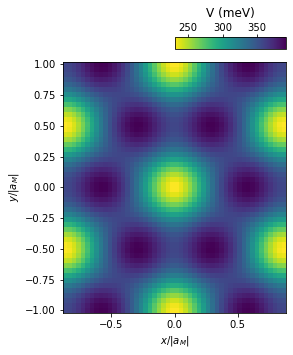

In [1111]:
params.plot_Delta(kind="DeltaT")

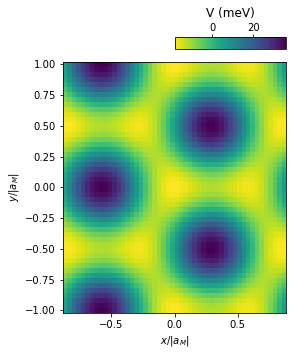

In [1112]:
params.plot_Delta(kind="Deltal")

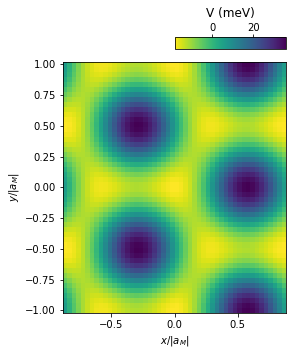

In [1113]:
params.plot_Delta(kind="Deltal",l=-1)

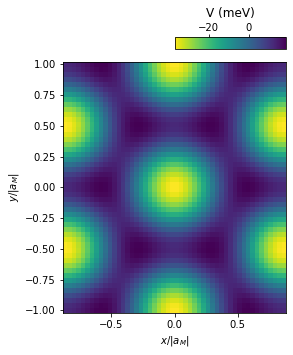

In [1114]:
params.plot_Delta(kind="Deltat+Deltab",)

In [20]:
params.phi

0.08224670334241131

Text(0, 1.05, '$\\phi=1.00\\pi$')

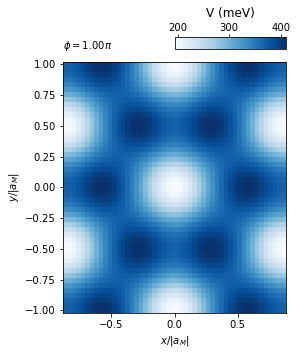

In [29]:
params=Params(Ez=0,phi=180)
ax=params.plot_Delta(kind="eigen",)
ax.text(0,1.05,r'$\phi={:.2f}\pi$'.format(params.phi/np.pi),transform=ax.transAxes)

/tmp/ipykernel_309/2073793064.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots(figsize=(4,8/params.aM1[0]*params.aM2[1]))


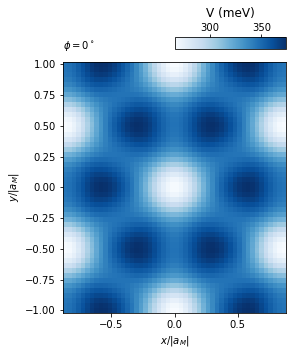

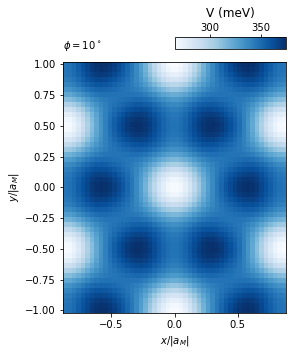

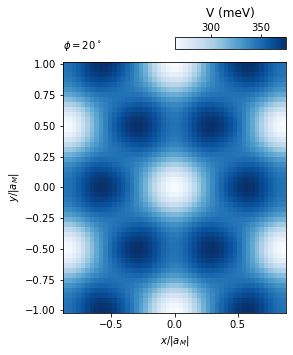

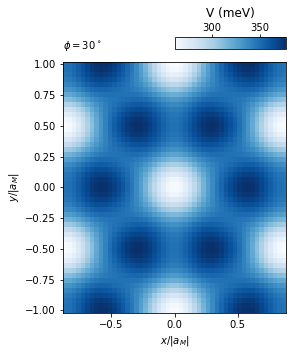

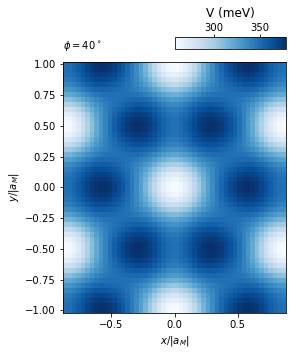

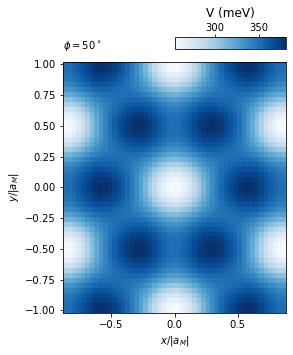

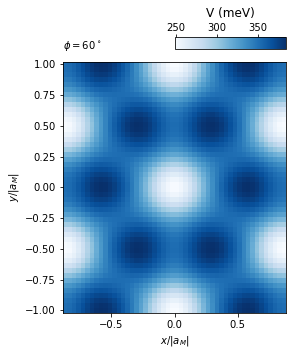

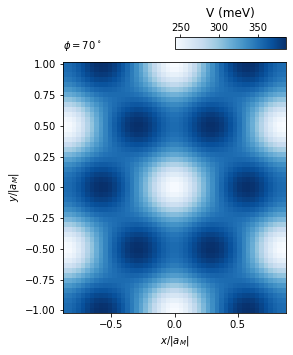

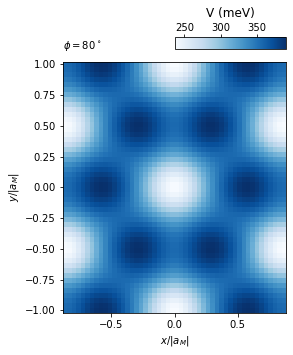

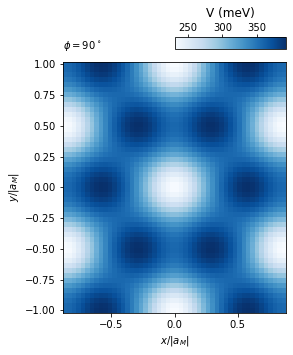

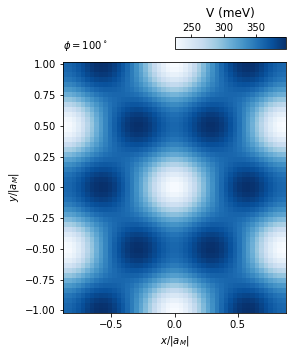

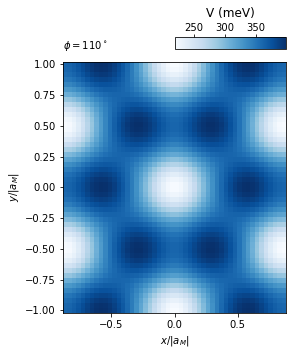

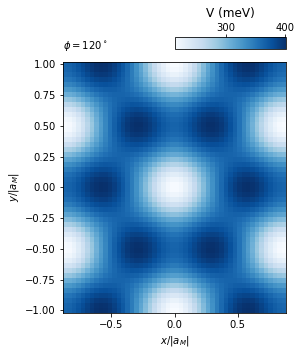

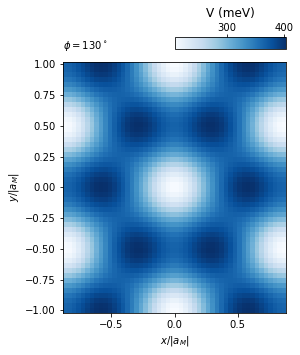

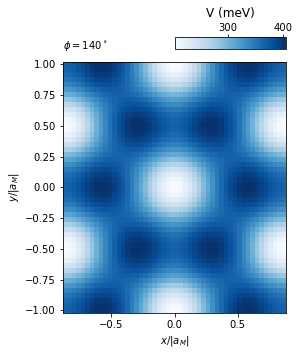

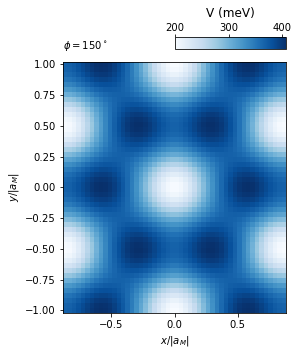

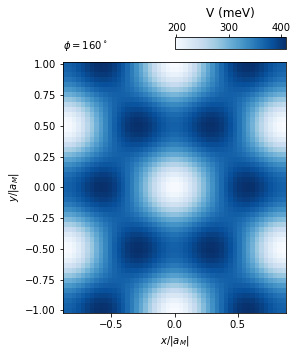

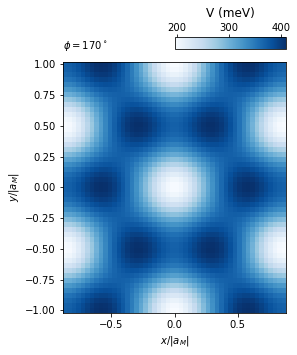

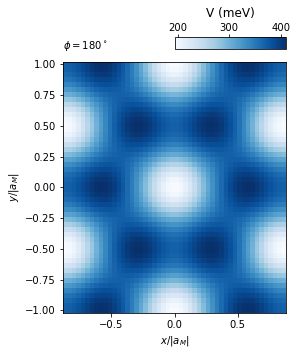

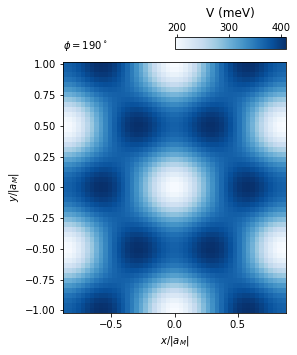

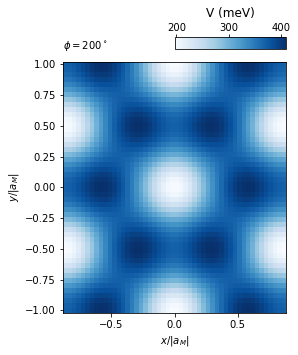

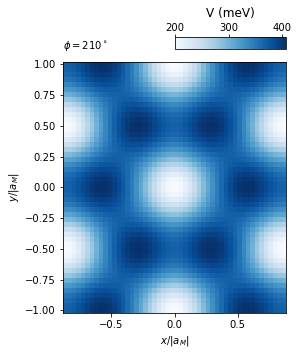

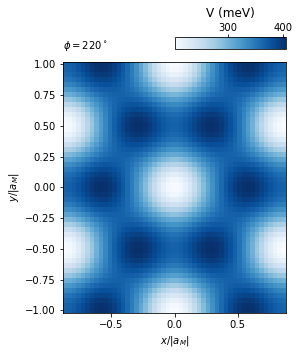

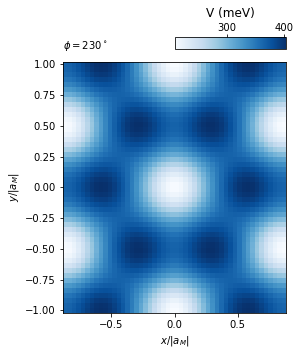

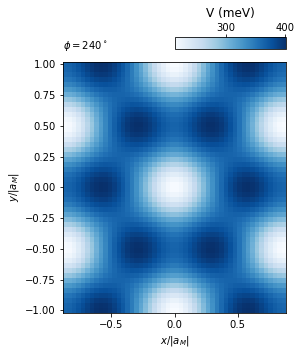

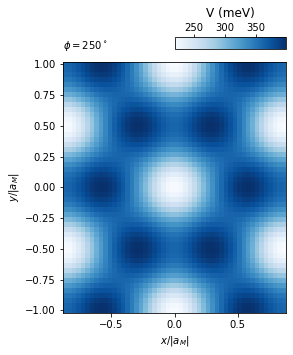

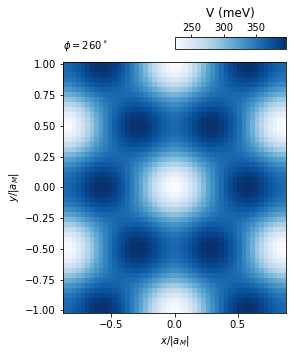

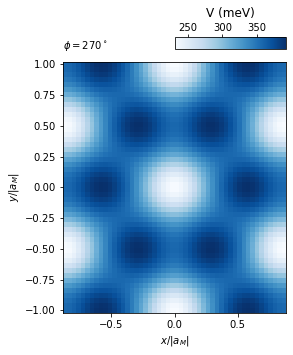

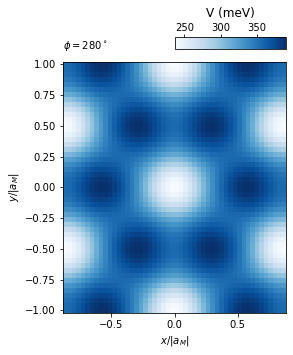

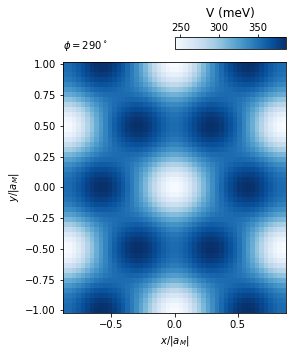

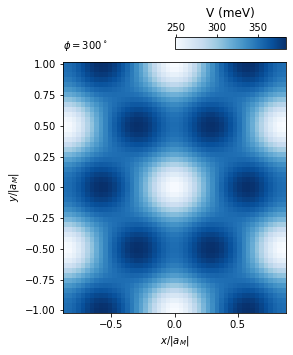

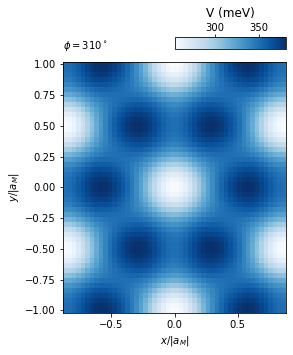

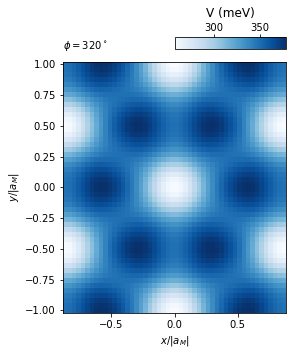

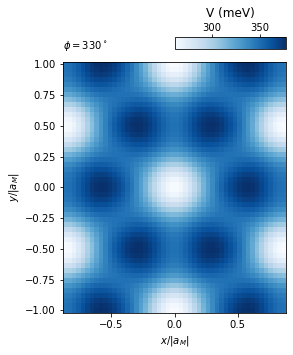

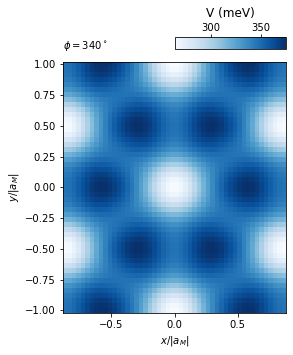

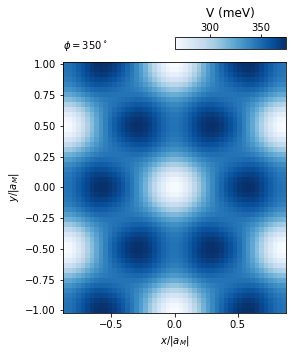

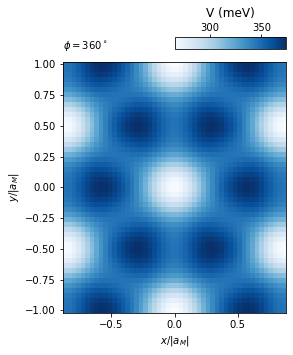

In [34]:
phi_list=np.linspace(0,360,37)
for phi in phi_list:
    params=Params(Ez=0,phi=phi)
    fig,ax=plt.subplots(figsize=(4,8/params.aM1[0]*params.aM2[1]))
    params.plot_Delta(kind="eigen",ax=ax)
    ax.text(0,1.05,r'$\phi={:.0f}^\circ $'.format(params.phi/np.pi*180),transform=ax.transAxes)
    fig.savefig('phi_{:.0f}.png'.format(params.phi/np.pi*180),dpi=1000)

array([[ 391.68998757,  361.85777954,  343.19611322, ..., -562.84612828,
        -562.84612828, -564.02251362],
       [ 391.65725536,  362.04891168,  343.24558929, ..., -564.71105398,
        -565.13863305, -568.6225151 ],
       [ 391.55945655,  362.59455618,  343.38955417, ..., -568.08275297,
        -568.27951366, -574.58990675],
       ...,
       [ 391.51617998,  362.82496936,  343.45853368, ..., -562.34674632,
        -573.47276097, -575.42019949],
       [ 391.64635919,  362.11153745,  343.26237471, ..., -562.12201047,
        -567.28093244, -569.2062404 ],
       [ 391.68998757,  361.85777954,  343.19611322, ..., -562.84612828,
        -562.84612828, -564.02251362]])

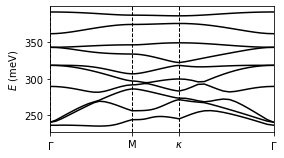

In [995]:
params.plot_dispersion()

In [650]:
energy_p_list[:,0].min()-energy_p_list[:,1].max()

0.00020625261959139607

In [1158]:
params=Params(Nmax=4,Ez=0)
params_E=Params(Nmax=4,Ez=40)

array([[  363.00808523,   336.37710802,   314.91065126, ...,
        -1087.74002765, -1087.74002765, -1087.75039228],
       [  362.97150437,   336.55012387,   314.95889318, ...,
        -1093.97321913, -1093.97325329, -1100.16414791],
       [  362.86200158,   337.04895732,   315.09938855, ...,
        -1100.32146716, -1100.32148396, -1112.70252313],
       ...,
       [  362.81344561,   337.2616882 ,   315.16630469, ...,
        -1088.00956014, -1112.76200428, -1112.7828345 ],
       [  362.95931948,   336.60701394,   314.97523443, ...,
        -1087.79963675, -1100.1712171 , -1100.19199641],
       [  363.00808523,   336.37710802,   314.91065126, ...,
        -1087.74002765, -1087.74002765, -1087.75039228]])

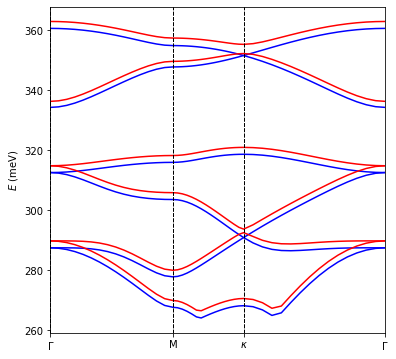

In [1159]:
fig,ax=plt.subplots(figsize=(6,6))
params.plot_dispersion(k=6,ax=ax,color='b')
params_E.plot_dispersion(k=6,ax=ax,color='r')
# ax.axhline(y=0,ls='dashed')

array([[ 351.51121589,  351.4342578 ,  318.2027202 , ..., -582.99728814,
        -637.37189249, -639.01608568],
       [ 351.91842054,  351.03117618,  318.19846332, ..., -580.95834495,
        -634.46914293, -637.84958222],
       [ 352.31480111,  350.62456366,  318.15459409, ..., -578.94507829,
        -631.09725873, -637.2311935 ],
       ...,
       [ 360.48715243,  335.12620135,  312.75760839, ..., -531.44370595,
        -542.76162982, -544.17877606],
       [ 360.63549165,  334.4784627 ,  312.5714836 , ..., -531.19278009,
        -536.54575607, -537.94312127],
       [ 360.68506187,  334.25123408,  312.50852361, ..., -531.63189801,
        -531.63189801, -532.58081545]])

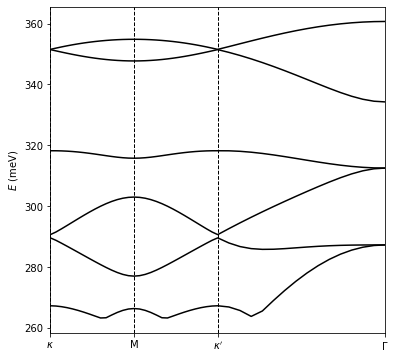

In [1147]:
fig,ax=plt.subplots(figsize=(6,6))
# params.plot_dispersion(k=6,ax=ax,line='K_M_Kp_G')
# ax.axhline(y=0,ls='dashed')

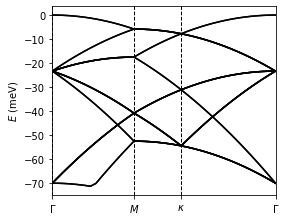

In [ ]:
params.plot_dispersion(k=20)

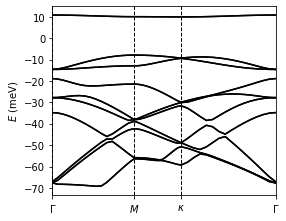

In [ ]:
params.plot_dispersion(k=20)

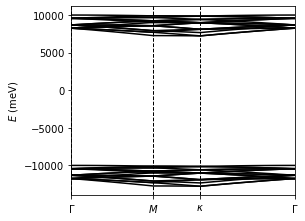

In [262]:
params.plot_dispersion(k=160)

In [191]:
params.energy_single(np.array([0]),np.array([0]))

(array([  343.00935582,   -58.53271583,   -81.16591427,   -81.16591427,
         -116.11490299,  -116.11490299,  -143.16062206,  -335.25443502,
         -747.11929428,  -763.02230449,  -763.02230449,  -787.3788894 ,
         -787.3788894 ,  -805.67408928,  -973.33770609,  -973.40306255,
         -973.40306255,  -974.22231994,  -974.22231994,  -974.87540772,
        -1408.67125462, -1411.47993002, -1411.47993002, -1417.08347729,
        -1417.08347729, -1419.90089736, -1650.31223114, -1650.31856586,
        -1650.31856586, -1650.72503897, -1650.72503897, -1651.06992774,
        -2086.23232089, -2087.92470886, -2087.92470886, -2091.33608043,
        -2091.33608043, -2093.04341957, -2706.37416175, -2706.41276702,
        -2706.41276702, -2706.48039593, -2706.48039593, -2706.50937411,
        -2745.96636215, -2746.04189382, -2746.04189382, -2746.20310372,
        -2746.20310372, -2746.28864883, -3388.29896935, -3388.32961621,
        -3388.32961621, -3388.39568855, -3388.39568855, -3388.43

In [563]:
params=Params(Nmax=3,V0=-6,w0=0,w1=0,w2=0,phi=121)

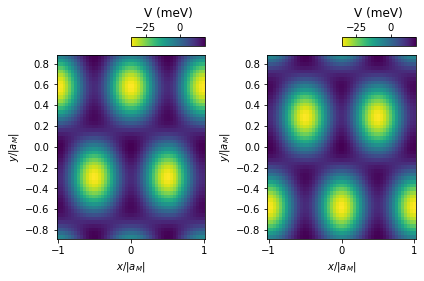

In [564]:
fig,axs=plt.subplots(1,2,tight_layout=True)
params.plot_Deltal(1,ax=axs[0])
params.plot_Deltal(-1,ax=axs[1])

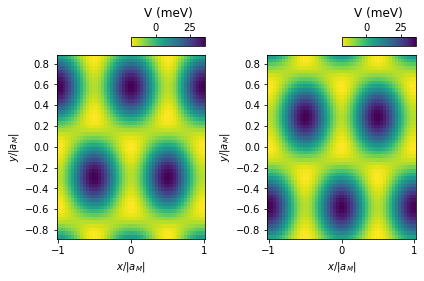

In [ ]:
fig,axs=plt.subplots(1,2,tight_layout=True)
params.plot_Deltal(1,ax=axs[0])
params.plot_Deltal(-1,ax=axs[1])

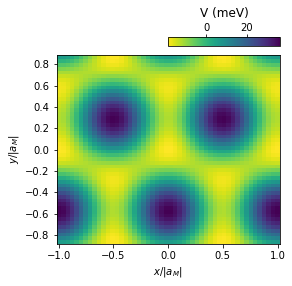

In [24]:
params.plot_Deltal(-1)

In [30]:
z=np.c_[[1,2,3],[2,3,4]]

In [37]:
np.sum(z*z,axis=1)

array([ 5, 13, 25])

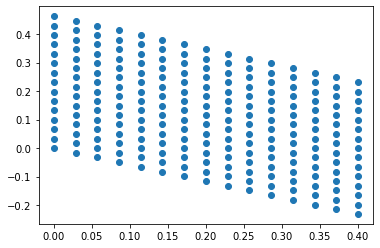

In [26]:
plt.scatter(*params.K.T)

In [39]:
(1.05457182e-34)**2/(2*9.1e-31)/(1e-10)**2/1.602e-19

3.8143314110730833

In [40]:
z

array([[1, 2],
       [2, 3],
       [3, 4]])

In [45]:
vec,val=np.linalg.eigh(np.diag(np.arange(5)))

In [46]:
vec

array([0., 1., 2., 3., 4.])

In [41]:
np.block([[z,z],[z,z]])

array([[1, 2, 1, 2],
       [2, 3, 2, 3],
       [3, 4, 3, 4],
       [1, 2, 1, 2],
       [2, 3, 2, 3],
       [3, 4, 3, 4]])

In [149]:
params.DeltaTmat

array([[338, -16,  -2, ...,   0,   0,   0],
       [-16, 338, -16, ...,   0,   0,   0],
       [ -2, -16, 338, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 338, -16,  -2],
       [  0,   0,   0, ..., -16, 338, -16],
       [  0,   0,   0, ...,  -2, -16, 338]])

In [150]:
params.DeltaTTmat

array([[338, -16,  -2, ...,   0,   0,   0],
       [-16, 338, -16, ...,   0,   0,   0],
       [ -2, -16, 338, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 338, -16,  -2],
       [  0,   0,   0, ..., -16, 338, -16],
       [  0,   0,   0, ...,  -2, -16, 338]])

In [155]:
params.G_idx

array([[ 1.00000000e+00, -5.55111512e-17],
       [ 0.00000000e+00,  1.00000000e+00],
       [-1.00000000e+00, -1.00000000e+00]])

In [158]:
params._Deltal(1,0,1)

(-3.0902284494603256+5.143003804212674j)

In [156]:
params.G_m_idx

array([[-1.00000000e+00,  5.55111512e-17],
       [-0.00000000e+00, -1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00]])

In [160]:
params.aM1

array([14.63998794,  0.        ])

In [162]:
params.bM

0.4955740049131804

In [154]:
params.Deltabmat

array([[ 0.        +0.j       , -3.09022845-5.1430038j,
         0.        +0.j       , ...,  0.        +0.j       ,
         0.        +0.j       ,  0.        +0.j       ],
       [-3.09022845+5.1430038j,  0.        +0.j       ,
        -3.09022845-5.1430038j, ...,  0.        +0.j       ,
         0.        +0.j       ,  0.        +0.j       ],
       [ 0.        +0.j       , -3.09022845+5.1430038j,
         0.        +0.j       , ...,  0.        +0.j       ,
         0.        +0.j       ,  0.        +0.j       ],
       ...,
       [ 0.        +0.j       ,  0.        +0.j       ,
         0.        +0.j       , ...,  0.        +0.j       ,
        -3.09022845-5.1430038j,  0.        +0.j       ],
       [ 0.        +0.j       ,  0.        +0.j       ,
         0.        +0.j       , ..., -3.09022845+5.1430038j,
         0.        +0.j       , -3.09022845-5.1430038j],
       [ 0.        +0.j       ,  0.        +0.j       ,
         0.        +0.j       , ...,  0.        +0.j       ,
 

In [152]:
params.Deltatmat

array([[ 0.        +0.j       , -3.09022845+5.1430038j,
         0.        +0.j       , ...,  0.        +0.j       ,
         0.        +0.j       ,  0.        +0.j       ],
       [-3.09022845-5.1430038j,  0.        +0.j       ,
        -3.09022845+5.1430038j, ...,  0.        +0.j       ,
         0.        +0.j       ,  0.        +0.j       ],
       [ 0.        +0.j       , -3.09022845-5.1430038j,
         0.        +0.j       , ...,  0.        +0.j       ,
         0.        +0.j       ,  0.        +0.j       ],
       ...,
       [ 0.        +0.j       ,  0.        +0.j       ,
         0.        +0.j       , ...,  0.        +0.j       ,
        -3.09022845+5.1430038j,  0.        +0.j       ],
       [ 0.        +0.j       ,  0.        +0.j       ,
         0.        +0.j       , ..., -3.09022845-5.1430038j,
         0.        +0.j       , -3.09022845+5.1430038j],
       [ 0.        +0.j       ,  0.        +0.j       ,
         0.        +0.j       , ...,  0.        +0.j       ,
 

In [135]:
params.h1matX

AttributeError: 'Params' object has no attribute 'h1matX'

In [66]:
params.am_index

array([[1., 0.],
       [0., 1.]])

In [74]:
params._get_h()

In [34]:
np.array([params.bM1,params.bM2])

array([[ 0.42917968, -0.247787  ],
       [ 0.        ,  0.495574  ]])

(-1.8883905819240372,
 1.8883905819240372,
 -2.180525621617994,
 2.180525621617994)

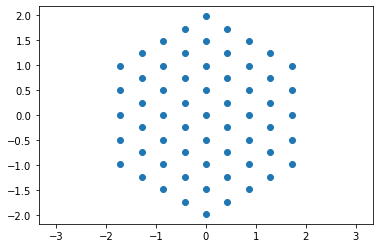

In [35]:
plt.scatter(*(params.neighbor_index@np.array([params.bM1,params.bM2])).T)
plt.axis('equal')

In [10]:
params.g/params.bM

array([[ 0.00000000e+00,  1.00000000e+00],
       [ 8.66025404e-01,  5.00000000e-01],
       [ 8.66025404e-01, -5.00000000e-01],
       [ 1.22464680e-16, -1.00000000e+00],
       [-8.66025404e-01, -5.00000000e-01],
       [-8.66025404e-01,  5.00000000e-01]])